## Load in all the modules needed

In [1]:
%pylab notebook
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, num2date
import numpy as np
import os
if os.name == 'nt':
    os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "Library", "share")
    os.environ["GDAL_DATA"] = os.path.join(os.environ["CONDA_PREFIX"], "Library", "share", "gdal")
import pandas as pd
from pathlib import Path
import re

from cetbtools.ease2conv import Ease2Transform

# the set_trace() command is helpful for entering interactive
# debugging mode to step through lines of code in this notebook
from IPython.core.debugger import set_trace

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Set pandas display options to display entire DataFrame, use None for all 
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 120)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 120)
pd.set_option('display.max_colwidth', 10)

In [3]:
# Define the local machine location of CETB data cubes
# This directory is expected to contain subdirectories in the following hierarchy
# that duplicates the hierarchy on the Google Shared Drive NSIDC-SD-CETB/v1/, 
# for example:
# dataDir/F13_SSMI/N/nc_cubes/cubes_<regionName>
user = 'Joan' #Mariah #MJWindows
if ('Joan' == user):
    dataDir = '/mnt/data3/cetb/nsidc0630_v1/' #jmr machine fringe 
    scriptDir = '/mnt/data3/cetb/ipynb_melt_onset/scripts'
elif ('Mariah' == user):
    dataDir = Path(Path.home(), 'nsidc0630_v1') # Mariah's PC or Mary Jo's Mac
    scriptDir = Path(Path.home(), 'ipynb_melt_onset', 'scripts')
elif ('MJWindows' == user):
    dataDir = Path('Z:/mj On My Mac/nsidc0630_v1') # Mary Jo's Windows machine
    scriptDir = Path(Path.home(), 'ipynb_melt_onset', 'scripts')
else:
    raise ValueError("unknown user= %s\n" % (user) )
    
%cd $scriptDir
dataDir, user

/mnt/data3/cetb/ipynb_melt_onset/scripts


('/mnt/data3/cetb/nsidc0630_v1/', 'Joan')

In [4]:
from CETB_read_functions import read_Tb
from CETB_read_functions import read_Tb_std_dev
from CETB_read_functions import coords
from CETB_read_functions import calc_DAV
from CETB_read_functions import read_Tb_whole
from CETB_read_functions import find_cube_offset
from CETB_read_functions import grid_locations_of_subset
from CETB_read_functions import years_for
from CETB_algorithms import DAV_MOD
from CETB_algorithms import XPGR
from CETB_algorithms import end_high_DAV
from CETB_algorithms import D_DAV
from CETB_algorithms import Winter_DAV
from CETB_analysis import Tb_hist_annual
from CETB_analysis import DAV_hist_annual
from CETB_analysis import Tb_hist_monthly
from CETB_analysis import DAV_hist_monthly
from CETB_analysis import TbDAV_series_one_year
from CETB_analysis import early_melt_events
from CETB_analysis import min_max_series
from CETB_analysis import MOD_array

## Specify inputs

In [5]:
#Specify region, satellite, sensor, channel, and image reconstruction algorithm of interest in file name
# this notebook will read in 2 CETB datasets so that channels/algorithms/sensors can be compared
region='AKYukon'  #make this the same syntax as cubefilenames and sub-directory #GLaIL
sat_GRD='F18'   #'AQUA' for AMSRE, 'F13','F14','F15'... for SSMI
sat_SIR= 'F18'
sensor_GRD='SSMIS'  #'AMSRE', 'SSMI', etc.
sensor_SIR='SSMIS'
channel_GRD='37V'  #'36V','36H', '18V','18H', etc. '19V','19H' and '37V','37H' for SSMI)
channel_SIR='37V'
alg_GRD='GRD'   #SIR or GRD
alg_SIR='SIR'


# set the sir to grd factor, depends on the channel
if (re.match('^[389]', channel_GRD)):
    sir_2_grd_factor = 8 # assume 3.125 km to 25 km
elif (re.match('^[12]', channel_GRD)):
    sir_2_grd_factor = 4 # assume 6.25 km to 25 km
else:
    raise ValueError("Cannot determine sir_2_grd_factor from channel %s\n" % (channel_GRD) )
    
cubeType_GRD = channel_GRD + '-' + alg_GRD
cubeType_SIR = channel_SIR + '-' + alg_SIR
  
if ('SSMI' == sensor_GRD) or ('SSMIS' == sensor_GRD):
    provider='CSU' 
    version='v1.*'
elif 'AMSRE' == sensor_GRD:
    provider='RSS'
    version='v1.3'


Years=years_for(sat_GRD)
#might want to truncate Years to subset if very slow during testing
#if we give it more years than available what do we want it to do? 
#warn me but return what it finds
    
hemName = 'N'    
    
# either change to the directory where the data is or specify it
datadir_GRD = "%s/%s_%s/%s/nc_cubes/cubes_%s" % (
    dataDir, sat_GRD, sensor_GRD, hemName, region)
datadir_SIR = "%s/%s_%s/%s/nc_cubes/cubes_%s" % (
    dataDir, sat_SIR, sensor_SIR, hemName, region)


# filepath patterns for each type of cubefile
prefix_GRD = "CETB.cubefile.%s.%s_%s-%s-%s-%s-%s" % (
    region, sat_GRD, sensor_GRD, channel_GRD, alg_GRD, provider, version)
prefix_SIR = "CETB.cubefile.%s.%s_%s-%s-%s-%s-%s" % (
    region, sat_SIR, sensor_SIR, channel_SIR, alg_SIR, provider, version)

# on MJ's machine
hemName = 'N'

#Enter a site name for titles of plots
# enter latitutde and longitude in decimal degrees

#Site='Low Relief Test, Alberta 49.73,-111.14'

#Site='Great Lakes Test Site, Lake Superior E of Duluth'
#lat_start=47.353097   
#lon_start=-89.861310

Site='Teshekpuk Lake 1'#near Barrow, AK (Permafrost installation NW margin of lake)'
lat_start=70.722902
lon_start=-153.836329

#Site='Teshekpuk Lake 2 center' #, near Barrow, AK (middle of lake)'
#lat_start=70.58333675326588
#lon_start=-153.452493001114"

#Site='NWT C57 04242006 Spring Migration'
#lat_start=62.61
#lon_start=-109.64

#Site='Great Slave Lake'
#lat_start=61.87167
#lon_start=-114.05

#Site='Iceland, Central Vatnajokull'
#lat_start=64.442   
#lon_start=-16.730 

#Site='Iceland, Katla Caldera Test'
#lat_start=63.64361111   
#lon_start=-19.20138889

#Site='Iceland, Vatnajokull Site 1'
#lat_start=64.64903   
#lon_start=-17.32128

#Site = 'Iceland, Vatnajokull Site 2'
#lat_start=64.25860278
#lon_start=-16.93241667

#Site='Iceland, Vatnajokull Site 3'
#lat_start=64.423333
#lon_start=-16.77305556
#Site='Iceland, Vatnajokull Site 4'
#lat_start=64.66222
#lon_start=-17.399444

#Site='Senator Beck Basin (SASP), Colorado'
#lat_start=37.9069   
#lon_start=-107.710

if Site=='Rabbit Ears':
    lat_start=40.5  #southern boundary
    lat_end=40.5  #northern boundary
    lon_start=-106.7  #western boundary
    lon_end=-106.7 #eastern boundary
elif Site=='Fraser':
    lat_start=39.85  #southern boundary
    lat_end=40.0  #northern boundary
    lon_start=-106.0  #western boundary
    lon_end=-105.9 #eastern boundary
elif Site=='North Park':
    lat_start=40.7  #southern boundary
    lat_end=40.7  #northern boundary
    lon_start=-106.15  #western boundary
    lon_end=-106.15 #eastern boundary
elif Site=='CLPX-LSA':
    lat_start=39.7  #southern boundary
    lat_end=41.0  #northern boundary
    lon_start=-106.7  #western boundary
    lon_end=-105.4 #eastern boundary
elif Site=='CUSTOM':
    lat_start=43  #southern boundary
    lat_end=43  #northern boundary
    lon_start=-110  #western boundary
    lon_end=-110 #eastern boundary
elif Site=='Senator Beck':
    # enter latitutde and longitude in decimal degrees
    lat_start=37.9069   #southern boundary
    lat_end=37.9069   #northern boundary
    lon_start=-107.726   #western boundary
    lon_end=-107.726 

In [6]:
# check that the GRD filename prefix is really what we have on the local machine
prefix_GRD

'CETB.cubefile.AKYukon.F18_SSMIS-37V-GRD-CSU-v1.*'

In [7]:
# get cube offset for finding row/col
find_cube_offset(region, cubeDir=datadir_SIR, cubeType=cubeType_SIR, verbose=False)

Reading offset information from cubeFile=/mnt/data3/cetb/nsidc0630_v1//F18_SSMIS/N/nc_cubes/cubes_AKYukon/CETB.cubefile.AKYukon.F18_SSMIS-37V-SIR-CSU-v1.3.2012.TB.nc...


(1791.9999999243946, 2063.999999943305)

In [8]:
# row and col numbers of the GRD pixels that include this region
rows_cols = grid_locations_of_subset(region, lat_start, lon_start, cubeDir=datadir_GRD)
rows_cols_GRD=[rows_cols[0][2],rows_cols[0][2]+1, rows_cols[1][2], rows_cols[1][2]+1]
rows_cols_GRD

Input lat, lon = 70.722902, -153.836329
 EASE2_N3.125km         : row, col = 2264.233867, 2577.235952
Reading offset information from cubeFile=/mnt/data3/cetb/nsidc0630_v1//F18_SSMIS/N/nc_cubes/cubes_AKYukon/CETB.cubefile.AKYukon.F18_SSMIS-37V-SIR-CSU-v1.3.2012.TB.nc...
        AKYukon(3?V-SIR): row, col = 472.233868, 513.235952
  EASE2_N6.25km         : row, col = 1131.866934, 1288.367976
Reading offset information from cubeFile=/mnt/data3/cetb/nsidc0630_v1//F18_SSMIS/N/nc_cubes/cubes_AKYukon/CETB.cubefile.AKYukon.F18_SSMIS-19V-SIR-CSU-v1.3.2012.TB.nc...
        AKYukon(1?V-SIR): row, col = 235.866934, 256.367976
    EASE2_N25km         : row, col = 282.591733, 321.716994
Reading offset information from cubeFile=/mnt/data3/cetb/nsidc0630_v1//F18_SSMIS/N/nc_cubes/cubes_AKYukon/CETB.cubefile.AKYukon.F18_SSMIS-19V-GRD-CSU-v1.3.2013.TB.nc...
        AKYukon(1?V-GRD): row, col = 58.591733, 63.716994
['EASE2_N3.125km', 'EASE2_N6.25km', 'EASE2_N25km']
513 472 256 236 64 59


[59, 60, 64, 65]

In [9]:
# row and col numbers of the envelope of 64 SIR pixels
#MJB: I am not convinced that this is a good approach to calculate these coordinates
#I need to look at this a little more closely
rows_cols_env=[rows_cols_GRD[0]*sir_2_grd_factor,rows_cols_GRD[1]*sir_2_grd_factor, rows_cols_GRD[2]*sir_2_grd_factor, rows_cols_GRD[3]*sir_2_grd_factor]
rows_cols_env

[472, 480, 512, 520]

In [10]:
#build the string that is the index to the SIR cell closest to our site
Site_nearest_row_col = "%s,%s" % (str(rows_cols[0][0]),str(rows_cols[1][0])) 

In [11]:
# check that the directory, filename pattern and Years are what we expect
# subset Years to a shorter set if only testing, because this takes a long time
Years = Years[9:10]
datadir_SIR, prefix_SIR, Years

('/mnt/data3/cetb/nsidc0630_v1//F18_SSMIS/N/nc_cubes/cubes_AKYukon',
 'CETB.cubefile.AKYukon.F18_SSMIS-37V-SIR-CSU-v1.*',
 [2019])

In [12]:
#new cell to read whole dataset
#takes a long time, for testing substitute a year for Years
data_SIR = read_Tb_whole(datadir_SIR, prefix_SIR, Years, rows_cols_env[0], rows_cols_env[1], rows_cols_env[2], rows_cols_env[3])

#FIXME: instead of copying these elements into new variables, just
#use the values directly in subsequent cells.  This is a more direct way to
#work with the output from the read_Tb_whole function.  It also would
#make it clear in subsequent cells that, for example "cal_month" is the
#month output from the SIR call.
CETB_SIR = data_SIR['TB']   # 3-D Tb time-series array
cal_date = data_SIR['cal_date']    # 1-D array of dates
cal_year = data_SIR['cal_year']    # 1-D array of years
cal_month = data_SIR['cal_month']   # 1-D array of months

#FIXME: same issue here, instead of copying the GRD TB data, subsequent
#cells should just use data_GRD['TB']
data_GRD = read_Tb_whole(datadir_GRD, prefix_GRD, Years, rows_cols_GRD[0], rows_cols_GRD[1], rows_cols_GRD[2], rows_cols_GRD[3])
CETB_GRD = data_GRD['TB']

Next filename=/mnt/data3/cetb/nsidc0630_v1//F18_SSMIS/N/nc_cubes/cubes_AKYukon/CETB.cubefile.AKYukon.F18_SSMIS-37V-SIR-CSU-v1.4.2019.TB.nc...
Next filename=/mnt/data3/cetb/nsidc0630_v1//F18_SSMIS/N/nc_cubes/cubes_AKYukon/CETB.cubefile.AKYukon.F18_SSMIS-37V-GRD-CSU-v1.4.2019.TB.nc...


In [13]:
#region version, may not need
# 'data' will be a tuple with the first element as the Tb time-series data, days, months, and years 
# to be used in plot/algorithm functions later
#data_SIR=read_Tb(datadir_SIR, prefix_SIR, Years,rows_cols_env[0],rows_cols_env[1],rows_cols_env[2],rows_cols_env[3])
#CETB_SIR=data_SIR[0]   # 3-D Tb time-series array
#cal_date=data_SIR[1]    # 1-D array of dates
#cal_year=data_SIR[2]    # 1-D array of years
#cal_month=data_SIR[3]   # 1-D array of months
#data_GRD=read_Tb(datadir_GRD, prefix_GRD, Years,rows_cols_GRD[0],rows_cols_GRD[1],rows_cols_GRD[2],rows_cols_GRD[3])
#CETB_GRD=data_GRD[0]

In [14]:
# calculate DAV for the Tb data that was imported
DAV_SIR = calc_DAV(CETB_SIR)
DAV_GRD = calc_DAV(CETB_GRD)

In [15]:
# calculate melt onset date, each row returned is the MOD for that year, 
# shows '3' with the first pixel in the subset to melt
# can tweak thresholds and count/window, legacy algorithm used 
# 3 occurrences in 5 day window
#DAV_threshold = 18
#Tb_threshold = 252
occurrences = 3
window = 10
DAV_threshold = 18
Tb_threshold = 252

In [16]:
#MOD_SIR1, melt_flag_df = DAV_MOD(DAV_threshold, Tb_threshold, occurrences, window, 
#                                 DAV_SIR, CETB_SIR, Years, cal_year, cal_date, 
#                                 rows_cols_env)
#MOD_SIR1

## MAPS

In [17]:
# Get lat/lon of each pixel in the subset of 64 in the data_SIR dict
lat_lon = np.dstack((data_SIR['latitude'], data_SIR['longitude']))
coordinates = lat_lon[rows_cols_env[0]:rows_cols_env[1],
                      rows_cols_env[2]:rows_cols_env[3]]
coordinates = coordinates.reshape(
    ((rows_cols_env[1]-rows_cols_env[0])*(rows_cols_env[3]-rows_cols_env[2])),
    2)

pixel_lats = coordinates[:,0]
pixel_lons = coordinates[:,1]
pixel_lats, pixel_lons

(masked_array(data=[70.70143448, 70.71398252, 70.72649694, 70.73897768,
                    70.75142468, 70.76383788, 70.77621721, 70.78856262,
                    70.72691146, 70.73947541, 70.75200573, 70.76450235,
                    70.7769652 , 70.78939423, 70.80178938, 70.81415057,
                    70.75237927, 70.76495918, 70.77750544, 70.79001797,
                    70.80249671, 70.81494161, 70.8273526 , 70.83972962,
                    70.77783789, 70.7904338 , 70.80299603, 70.81552451,
                    70.82801918, 70.84047999, 70.85290687, 70.86529975,
                    70.8032873 , 70.81589923, 70.82847747, 70.84102194,
                    70.85353258, 70.86600934, 70.87845213, 70.89086091,
                    70.82872745, 70.84135546, 70.85394974, 70.86651024,
                    70.87903688, 70.89152962, 70.90398838, 70.91641309,
                    70.85415832, 70.86680244, 70.87941281, 70.89198937,
                    70.90453206, 70.91704081, 70.92951557, 70.94

In [18]:
# Get lat/lon of the GRD pixel
lat_lon_GRD = np.dstack((data_GRD['latitude'], data_GRD['longitude']))
coordinates = lat_lon_GRD[rows_cols_GRD[0]:rows_cols_GRD[1],
                          rows_cols_GRD[2]:rows_cols_GRD[3]]
coordinates = coordinates.reshape(
    ((rows_cols_GRD[1]-rows_cols_GRD[0])*(rows_cols_GRD[3]-rows_cols_GRD[2])),
    2)

pixel_lats_GRD = coordinates[:,0]
pixel_lons_GRD = coordinates[:,1]
pixel_lats_GRD, pixel_lons_GRD

(masked_array(data=[70.83452992],
              mask=False,
        fill_value=1e+20),
 masked_array(data=[-153.88608737],
              mask=False,
        fill_value=1e+20))

# New output from MOD_array

MOD_DOY_array: this is a masked array (used to be the only thing Mitch returned), contains doy of average melt over all years for each pixel

MOD_DOY_df: MJB: I think this is more useful, it is a data frame with 1 row for each pixel, and 1 column for each year, plus an extra column for the 'Avg' Contents of the data are doy of first time melt criteria were met. 'Avg' column is the contents of MOD_DOY_array

meltflag_df: This may also be useful for further analysis, 1 row for each date (2 dates per day), 1 column for each pixel. Values are 1 if DAV/TB thresholds were exceeded on this date, 0 otherwise.

In [19]:
# get array of MODs for each pixel in the 64 set to use for map
# This will contain each year and the Avg MOD for all years
window = 10
count = 3
DAV_threshold = 18
Tb_threshold = 252
MOD_DOY_array, MOD_DOY_df, meltflag_df = MOD_array(
    datadir_SIR, prefix_SIR, CETB_SIR, DAV_SIR, rows_cols_env, cal_date, 
    Years, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_df

newdata.shape (730, 64)
moving flag array to newdata...
number of days = 730
Next d = 0
Next d = 100
Next d = 200
Next d = 300
Next d = 400
Next d = 500
Next d = 600
Next d = 700
dataFrame is ready with flag data
doing rolling sums...
Next year = 2019...


,2019,Avg
"(row,col)",,
"472,512",135,135.0
"472,513",135,135.0
"472,514",135,135.0
"472,515",135,135.0
"472,516",135,135.0
"472,517",135,135.0
"472,518",135,135.0
"472,519",135,135.0
"473,512",135,135.0


In [20]:
# MOD of the GRD pixel 
# Use the same thresholds/criteria as for SIR
MOD_DOY_array_GRD, MOD_DOY_GRD_df, meltflag_GRD_df = MOD_array(
    datadir_GRD, prefix_GRD, CETB_GRD, DAV_GRD, rows_cols_GRD, cal_date, 
    Years, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_GRD_df

newdata.shape (730, 1)
moving flag array to newdata...
number of days = 730
Next d = 0
Next d = 100
Next d = 200
Next d = 300
Next d = 400
Next d = 500
Next d = 600
Next d = 700
dataFrame is ready with flag data
doing rolling sums...
Next year = 2019...


,2019,Avg
"(row,col)",,
"59,64",134,134.0


In [21]:
# Trial-and-error decide on size for GRD vs. SIR scatter markers
#np.sqrt((1200)/8)^2
sSIR = 100
sGRD = 3200

<IPython.core.display.Javascript object>


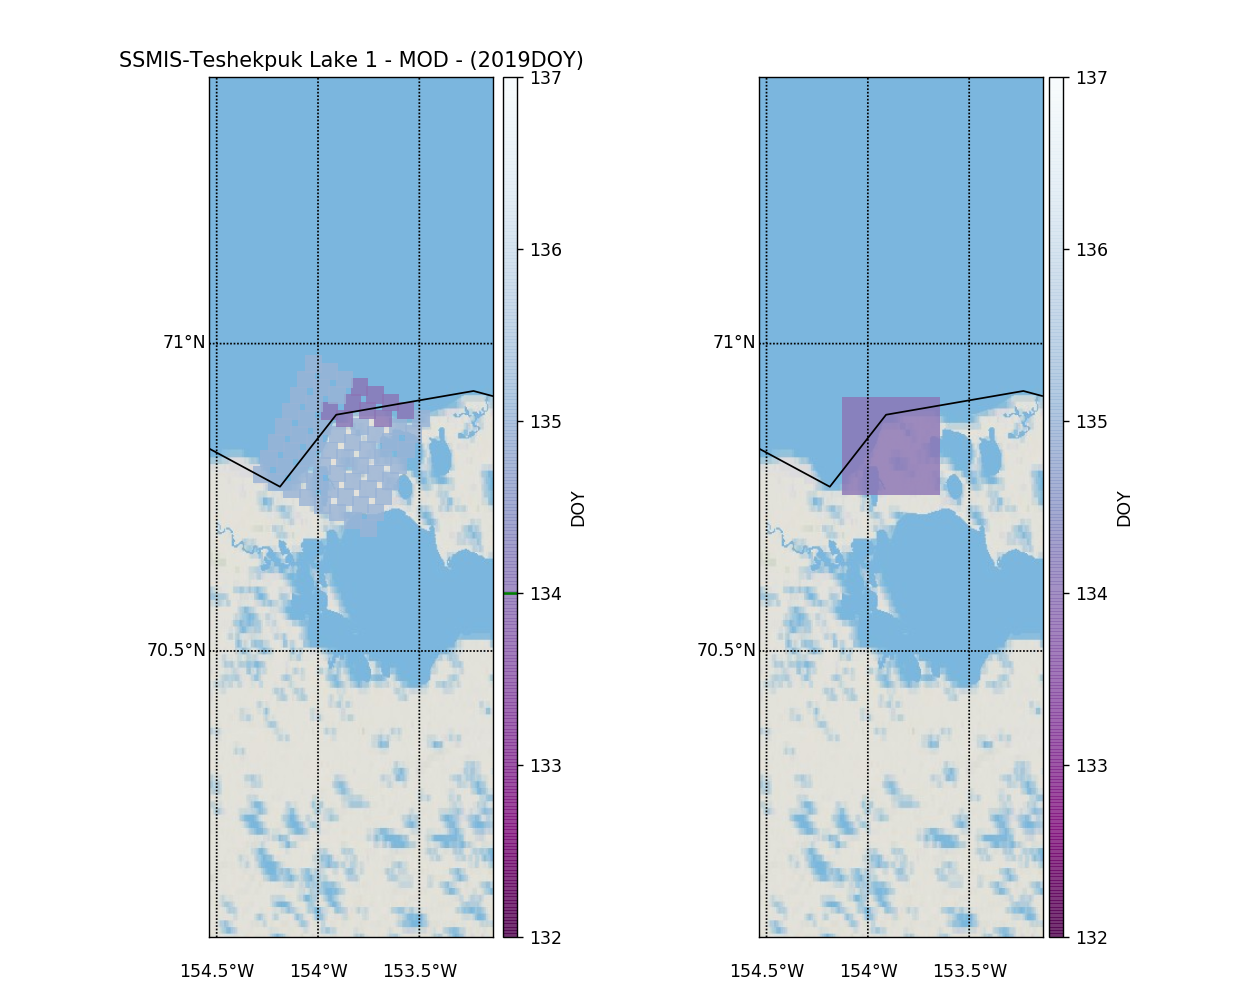

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-17202905.453341793,11076173.816537216,-17047058.166231215,11548446.09584224&bboxSR=3857&imageSR=3857&size=1500,4545&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-17202905.453341793,11076173.816537216,-17047058.166231215,11548446.09584224&bboxSR=3857&imageSR=3857&size=1500,4545&dpi=96&format=png32&transparent=true&f=image


In [22]:
# PLOT the MOD MAP - avg of all years or one year of interest
# Decide here:
plot_type='all' # DO THIS to show avg of all years
# OR
plot_type='year' # DO THIS and choose a year for 1 year of interest
year=2019

if plot_type == 'all':
    SIR_array = MOD_DOY_df['Avg'].values
    GRD_array = MOD_DOY_GRD_df['Avg'].values
    label = 'Avg DOY ' + str(Years[0]) + '-' + str(Years[-1])
    title = sensor_SIR + '-' + Site + ' - MOD - (' + label + ')'
elif plot_type == 'year':
    SIR_array = MOD_DOY_df[year].values
    GRD_array = MOD_DOY_GRD_df[year].values
    label = str(year) + 'DOY' 
    title = sensor_SIR + '-' + Site + ' - MOD - (' + label + ')'

# Set a few common things
#min day of year to plot--look at both data arrays and subtract 2 days
minday = np.amin([np.amin(GRD_array), np.amin(SIR_array)]) - 2
#max day of year to plot same here but add 2 days
maxday = np.amax([np.amax(GRD_array), np.amax(SIR_array)]) + 2

graticule_fontsize = 4

fig, axes = plt.subplots(1, 2, figsize=(10,8))

axes[0].set_title(title)
# create polar stereographic Basemap instance.
m = Basemap(ax=axes[0], projection='stere',lon_0=lon_start,lat_0=lat_start,lat_ts=90.,\
            llcrnrlat=(lat_start-.7),urcrnrlat=(lat_start+.7),\
            llcrnrlon=(lon_start-.7),urcrnrlon=(lon_start+.7),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

x,y = m(pixel_lons, pixel_lats)
#m.plot(x,y, 'bs', markersize=11, markeredgewidth=1, alpha=0.2)
im0 = m.scatter(x, y, c=SIR_array, s=sSIR, marker='s', lw=0, cmap='BuPu_r', alpha=.8,
          vmin=minday, vmax=maxday)

# Get the current axes and configure placement so colorbar will
# be 5% of ax width and the padding will be 0.08 in.
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.08)
cbar = plt.colorbar(im0, cax=cax, label='DOY')
cbar.set_clim(minday, maxday)  #color bar limits

# plot a red line on colorbar for the MOD for the GRD pixel
cbar.ax.hlines(cbar.norm(GRD_array[0]), 0, 1, color='green') 

# create polar stereographic Basemap instance.
m = Basemap(ax=axes[1], projection='stere',lon_0=lon_start,lat_0=lat_start,lat_ts=90.,\
            llcrnrlat=(lat_start-.7),urcrnrlat=(lat_start+.7),\
            llcrnrlon=(lon_start-.7),urcrnrlon=(lon_start+.7),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

x,y = m(pixel_lons_GRD, pixel_lats_GRD)
#m.plot(x,y, 'bs', markersize=11, markeredgewidth=1, alpha=0.2)
im1 = m.scatter(x, y, c=GRD_array, s=sGRD, marker='s', lw=0, cmap='BuPu_r', alpha=.8,
          vmin=minday, vmax=maxday)          

# Get the current axes and configure placement so colorbar will
# be 5% of ax width and the padding will be 0.05 in.
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im1, cax=cax, label='DOY')
cbar.set_clim(minday, maxday)  #color bar limits

plt.tight_layout(pad=3.0)
plt.show()

In [23]:
# load SIR Tb standard deviation data from netCDF file with function
Tb_std_dev=read_Tb_std_dev(datadir_SIR, prefix_SIR, Years,rows_cols_env[0],rows_cols_env[1],rows_cols_env[2],rows_cols_env[3])
#Tb_std_dev

> /mnt/data3/cetb/ipynb_melt_onset/scripts/CETB_read_functions.py(215)read_Tb_std_dev()
    213 def read_Tb_std_dev(datadir, prefix, Years,y_start,y_end,x_start,x_end):
    214     pdb.set_trace()
--> 215     for year in Years:
    216         # Create filename
    217         cubePattern = "%s/%s.%4d.TB_std_dev.nc" % (datadir, prefix, year)

ipdb> c
Next filename=/mnt/data3/cetb/nsidc0630_v1//F18_SSMIS/N/nc_cubes/cubes_AKYukon/CETB.cubefile.AKYukon.F18_SSMIS-37V-SIR-CSU-v1.4.2019.TB_std_dev.nc...


In [24]:
Tb_std_dev.shape

(730, 8, 8)

In [25]:
#need to run this cell for the max DAV to work
y_dims_list=list(range(len(CETB_SIR[0,:,0])))  # creates a list of the y-dimension pixel indices, used for plotting
x_dims_list=list(range(len(CETB_SIR[0,0,:])))	# creates a list of the x-dimension pixel indices, for plotting
y_s=list(range(rows_cols_env[0],rows_cols_env[1]))  # makes a list of the y(row) numbers so the dataframe of early melt events can be indexed
x_s=list(range(rows_cols_env[2],rows_cols_env[3]))  # makes a list of the x(col) numbers so the dataframe of early melt events can be indexed

# create dataframe of the 64 SIR pixels
Tb_std_frame=pd.DataFrame()
for i in y_dims_list:
    for j in x_dims_list:
        column=pd.DataFrame(data=Tb_std_dev[:,i,j], columns=[str(y_s[i])+','+str(x_s[j])])
        Tb_std_frame=pd.concat([Tb_std_frame,column],axis=1)
Tb_std_frame.index=cal_date
Tb_std_frame

,"472,512","472,513","472,514","472,515","472,516",...,"479,515","479,516","479,517","479,518","479,519"
2019-01-01 06:00:00,1.36,1.43,1.51,1.51,1.57,...,1.61,1.65,1.70,1.65,1.60
2019-01-01 18:00:00,1.95,2.05,2.18,2.24,2.35,...,1.93,1.87,2.06,2.05,2.05
2019-01-02 06:00:00,0.92,0.93,0.96,0.96,1.07,...,1.06,1.17,1.23,1.28,1.32
2019-01-02 18:00:00,1.47,1.61,1.74,1.75,1.82,...,1.92,1.90,1.87,1.80,1.80
2019-01-03 06:00:00,0.94,0.97,0.99,1.00,0.99,...,1.14,1.15,1.20,1.26,1.30
2019-01-03 18:00:00,1.41,1.44,1.49,1.51,1.54,...,1.77,1.72,1.65,1.53,1.48
2019-01-04 06:00:00,1.33,1.39,1.44,1.55,1.68,...,1.88,1.89,1.94,1.91,1.89
2019-01-04 18:00:00,1.33,1.36,1.39,1.38,1.37,...,1.61,1.57,1.53,1.46,1.34
2019-01-05 06:00:00,1.77,1.82,1.89,1.97,2.05,...,1.97,1.99,1.97,1.98,1.93
2019-01-05 18:00:00,1.09,1.09,1.16,1.17,1.21,...,1.25,1.22,1.20,1.19,1.18


In [26]:
# load dataframe of Tb GRD for plotting Tb on specified day and observation
Tb_std_dev_GRD=read_Tb_std_dev(datadir_GRD, prefix_GRD, Years,rows_cols_GRD[0],rows_cols_GRD[1],rows_cols_GRD[2],rows_cols_GRD[3])
Tb_std_dev_GRD

> /mnt/data3/cetb/ipynb_melt_onset/scripts/CETB_read_functions.py(215)read_Tb_std_dev()
    213 def read_Tb_std_dev(datadir, prefix, Years,y_start,y_end,x_start,x_end):
    214     pdb.set_trace()
--> 215     for year in Years:
    216         # Create filename
    217         cubePattern = "%s/%s.%4d.TB_std_dev.nc" % (datadir, prefix, year)

ipdb> c
Next filename=/mnt/data3/cetb/nsidc0630_v1//F18_SSMIS/N/nc_cubes/cubes_AKYukon/CETB.cubefile.AKYukon.F18_SSMIS-37V-GRD-CSU-v1.4.2019.TB_std_dev.nc...


masked_array(
  data=[[[3.049999952316284]],

        [[5.449999809265137]],

        [[2.299999952316284]],

        [[2.8299999237060547]],

        [[3.4499998092651367]],

        [[4.529999732971191]],

        [[4.769999980926514]],

        [[3.68999981880188]],

        [[4.159999847412109]],

        [[3.569999933242798]],

        [[4.099999904632568]],

        [[6.440000057220459]],

        [[3.619999885559082]],

        [[5.519999980926514]],

        [[2.669999837875366]],

        [[4.159999847412109]],

        [[3.799999952316284]],

        [[5.519999980926514]],

        [[1.709999918937683]],

        [[4.869999885559082]],

        [[2.1499998569488525]],

        [[3.9800000190734863]],

        [[1.9199999570846558]],

        [[3.7300000190734863]],

        [[3.609999895095825]],

        [[3.5]],

        [[3.93999981880188]],

        [[5.699999809265137]],

        [[3.5]],

        [[6.440000057220459]],

        [[2.5899999141693115]],

        [[4.96999

In [27]:
# slice of dataframe described above
Tb_sd_frame_GRD=pd.DataFrame(Tb_std_dev_GRD[:,0,0], index=cal_date)
Tb_sd_frame_GRD

,0
2019-01-01 06:00:00,3.050000
2019-01-01 18:00:00,5.450000
2019-01-02 06:00:00,2.300000
2019-01-02 18:00:00,2.830000
2019-01-03 06:00:00,3.450000
2019-01-03 18:00:00,4.530000
2019-01-04 06:00:00,4.770000
2019-01-04 18:00:00,3.690000
2019-01-05 06:00:00,4.160000
2019-01-05 18:00:00,3.570000


In [28]:
# load dataframe of Tb GRD for plotting Tb on specified day and observation
Tb_frame_GRD=pd.DataFrame(CETB_GRD[:,0,0], index=cal_date)
Tb_frame_GRD

,0
2019-01-01 06:00:00,233.97...
2019-01-01 18:00:00,237.54...
2019-01-02 06:00:00,233.81...
2019-01-02 18:00:00,239.54...
2019-01-03 06:00:00,235.83...
2019-01-03 18:00:00,234.08...
2019-01-04 06:00:00,230.08...
2019-01-04 18:00:00,228.81...
2019-01-05 06:00:00,228.77...
2019-01-05 18:00:00,227.44...


In [29]:
# load dataframe of Tb SIR for plotting Tb on specified day and observation
Tb_frame=pd.DataFrame()
for i in y_dims_list:
    for j in x_dims_list:
        column=pd.DataFrame(data=CETB_SIR[:,i,j], columns=[str(y_s[i])+','+str(x_s[j])])
        Tb_frame=pd.concat([Tb_frame,column],axis=1)
Tb_frame.index=cal_date
Tb_frame

,"472,512","472,513","472,514","472,515","472,516",...,"479,515","479,516","479,517","479,518","479,519"
2019-01-01 06:00:00,228.79...,228.87...,229.39...,229.51...,229.90...,...,239.09...,240.93...,241.51...,242.04...,243.44...
2019-01-01 18:00:00,230.75...,230.75...,231.67...,231.22...,232.20...,...,246.62...,248.41...,247.64...,247.41...,247.16...
2019-01-02 06:00:00,230.62...,230.87...,230.47...,229.77...,230.37...,...,239.98...,241.38...,242.09...,242.90...,244.54...
2019-01-02 18:00:00,233.45...,233.33...,233.73...,233.27...,233.34...,...,245.16...,246.39...,246.86...,247.79...,248.38...
2019-01-03 06:00:00,228.78...,229.11...,228.95...,229.05...,228.08...,...,238.86...,240.55...,241.47...,241.78...,243.61...
2019-01-03 18:00:00,229.83...,229.61...,229.12...,228.78...,228.88...,...,241.23...,242.53...,242.91...,243.62...,243.86...
2019-01-04 06:00:00,223.54...,223.86...,223.72...,223.19...,224.19...,...,234.76...,235.59...,236.79...,238.26...,239.19...
2019-01-04 18:00:00,224.00...,224.01...,224.00...,223.52...,223.62...,...,236.22...,237.19...,237.42...,237.36...,238.36...
2019-01-05 06:00:00,224.44...,224.25...,225.02...,224.81...,224.83...,...,233.75...,235.06...,236.28...,236.86...,238.26...
2019-01-05 18:00:00,222.77...,222.55...,223.12...,223.36...,223.41...,...,234.53...,235.43...,235.58...,236.06...,237.00...


In [30]:
# get the min and max Tb of the 64 for each time step
Tb_64_min=Tb_frame.min(axis=1)
Tb_64_max=Tb_frame.max(axis=1)

In [31]:
# compute std dev of the 64 SIR pixels
Tb_std_64=Tb_frame.std(axis=1)
Tb_std_64

2019-01-01 06:00:00    3.797074
2019-01-01 18:00:00    4.996021
2019-01-02 06:00:00    3.693963
2019-01-02 18:00:00    4.256669
2019-01-03 06:00:00    4.000643
2019-01-03 18:00:00    4.288804
2019-01-04 06:00:00    4.253243
2019-01-04 18:00:00    4.265431
2019-01-05 06:00:00    3.624058
2019-01-05 18:00:00    3.997683
2019-01-06 06:00:00    3.295178
2019-01-06 18:00:00    4.972987
2019-01-07 06:00:00    3.237464
2019-01-07 18:00:00    4.581330
2019-01-08 06:00:00    3.366744
2019-01-08 18:00:00    4.203649
2019-01-09 06:00:00    3.307175
2019-01-09 18:00:00    3.808090
2019-01-10 06:00:00    3.275380
2019-01-10 18:00:00    3.867157
2019-01-11 06:00:00    3.202151
2019-01-11 18:00:00    3.655030
2019-01-12 06:00:00    3.607471
2019-01-12 18:00:00    3.912281
2019-01-13 06:00:00    2.944529
2019-01-13 18:00:00    4.153384
2019-01-14 06:00:00    3.009330
2019-01-14 18:00:00    4.461264
2019-01-15 06:00:00    3.361474
2019-01-15 18:00:00    4.500468
2019-01-16 06:00:00    3.601485
2019-01-

In [32]:
# take difference of the GRD_std_dev variable and the computed sd of the 64 SIR pixels
Tb_sd_diff=Tb_sd_frame_GRD[0]-Tb_std_64
Tb_sd_diff

2019-01-01 06:00:00    -0.747074
2019-01-01 18:00:00     0.453979
2019-01-02 06:00:00    -1.393963
2019-01-02 18:00:00    -1.426669
2019-01-03 06:00:00    -0.550643
2019-01-03 18:00:00     0.241196
2019-01-04 06:00:00     0.516757
2019-01-04 18:00:00    -0.575432
2019-01-05 06:00:00     0.535942
2019-01-05 18:00:00    -0.427683
2019-01-06 06:00:00     0.804821
2019-01-06 18:00:00     1.467013
2019-01-07 06:00:00     0.382536
2019-01-07 18:00:00     0.938670
2019-01-08 06:00:00    -0.696744
2019-01-08 18:00:00    -0.043649
2019-01-09 06:00:00     0.492825
2019-01-09 18:00:00     1.711910
2019-01-10 06:00:00    -1.565380
2019-01-10 18:00:00     1.002843
2019-01-11 06:00:00    -1.052151
2019-01-11 18:00:00     0.324970
2019-01-12 06:00:00    -1.687471
2019-01-12 18:00:00    -0.182281
2019-01-13 06:00:00     0.665471
2019-01-13 18:00:00    -0.653384
2019-01-14 06:00:00     0.930670
2019-01-14 18:00:00     1.238736
2019-01-15 06:00:00     0.138526
2019-01-15 18:00:00     1.939532
2019-01-16

In [33]:
DAV_GRD_frame=pd.DataFrame(DAV_GRD[:,0,0], index=cal_date)
DAV_GRD_frame

,0
2019-01-01 06:00:00,0.000000
2019-01-01 18:00:00,3.569992
2019-01-02 06:00:00,3.729996
2019-01-02 18:00:00,5.729996
2019-01-03 06:00:00,3.709991
2019-01-03 18:00:00,1.750000
2019-01-04 06:00:00,4.000000
2019-01-04 18:00:00,1.270004
2019-01-05 06:00:00,0.039993
2019-01-05 18:00:00,1.330002


In [34]:
DAV_SIR_frame=pd.DataFrame()
for i in y_dims_list:
    for j in x_dims_list:
        column=pd.DataFrame(data=DAV_SIR[:,i,j], columns=[str(y_s[i])+','+str(x_s[j])])
        DAV_SIR_frame=pd.concat([DAV_SIR_frame,column],axis=1)
DAV_SIR_frame['Date']=cal_date        
DAV_SIR_frame=DAV_SIR_frame.set_index('Date')
DAV_SIR_frame

,"472,512","472,513","472,514","472,515","472,516",...,"479,515","479,516","479,517","479,518","479,519"
Date,,,,,,,,,,,
2019-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-01 18:00:00,1.960007,1.880005,2.279999,1.700012,2.300003,...,7.529999,7.480011,6.130005,5.370010,3.720001
2019-01-02 06:00:00,0.130005,0.119995,1.209991,1.440002,1.830002,...,6.639999,7.029999,5.550003,4.510010,2.620010
2019-01-02 18:00:00,2.830002,2.450012,3.269989,3.500000,2.970001,...,5.180008,5.009995,4.770004,4.889999,3.840012
2019-01-03 06:00:00,4.669998,4.220001,4.779999,4.220001,5.269989,...,6.300003,5.839996,5.399994,6.009995,4.779999
2019-01-03 18:00:00,1.050003,0.500000,0.169998,0.270004,0.809998,...,2.369995,1.979996,1.449997,1.839996,0.259995
2019-01-04 06:00:00,6.290009,5.750000,5.409988,5.599991,4.690002,...,6.470001,6.940002,6.120010,5.360001,4.669998
2019-01-04 18:00:00,0.450012,0.159988,0.279999,0.339996,0.570007,...,1.450012,1.600006,0.630005,0.899994,0.839996
2019-01-05 06:00:00,0.440002,0.230011,1.029999,1.289993,1.210007,...,2.460007,2.130005,1.139999,0.509995,0.090012


In [37]:
Tb_nearest=DAV_SIR_frame[Site_nearest_row_col]

In [39]:
%pwd

'/mnt/data3/cetb/ipynb_melt_onset/scripts'

<IPython.core.display.Javascript object>


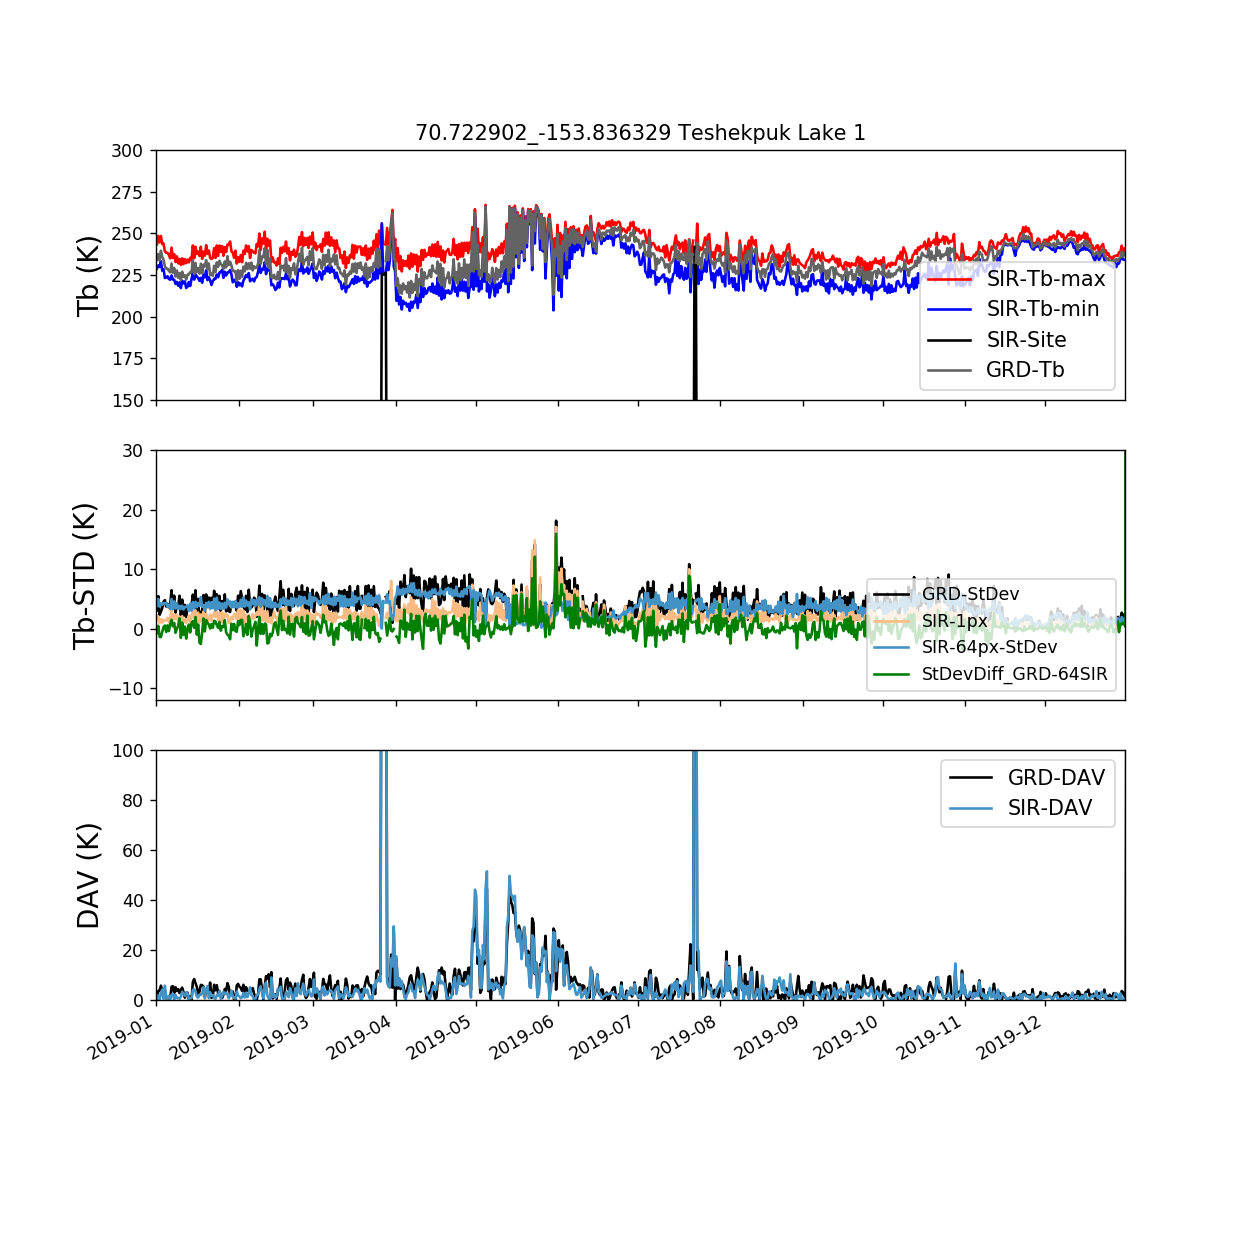

In [40]:
#Generate a time series of specified length (any window in dataset)
#Make sure to update filename in last line to export new file
fig,(ax1,ax2,ax3)=plt.subplots(3,1, sharex=True, figsize=(10,10))
#ax.xlim('2003-1-1', '2011-12-31')
ax1.set_title(str(lat_start)+'_'+str(lon_start)+' '+Site)
#Tb_sd_frame_GRD.plot(xlim=['2019-01-01','2019-12-31'])

ax1.plot(Tb_64_max, color='red', label='SIR-Tb-max')
ax1.plot(Tb_64_min, color='blue', label='SIR-Tb-min')
ax1.plot(Tb_nearest, color = 'black',label='SIR-Site')
ax1.plot(Tb_frame_GRD, color='#636363', label='GRD-Tb')
ax1.set_ylabel('Tb (K)', fontsize=16)
ax1.set_ylim(150,300)
#ax1.yticks(fontsize=12)
ax1.legend(fontsize=12)
ax2.plot(Tb_sd_frame_GRD, color='black', label='GRD-StDev')
ax2.plot(Tb_std_frame[str(rows_cols[0][0])+','+str(rows_cols[1][0])], color='#fdbb84', label='SIR-1px')
ax2.set_ylabel('Tb-STD (K)',fontsize=16)
ax2.plot(Tb_std_64, color='#4292c6',label='SIR-64px-StDev')
ax2.plot(Tb_sd_diff, label='StDevDiff_GRD-64SIR', color='green')
ax2.legend(fontsize=10,loc='lower right')
ax2.set_ylim(-12,30)
ax3.plot(DAV_GRD_frame, color='black', label='GRD-DAV')
ax3.plot(DAV_SIR_frame[str(rows_cols[0][0])+','+str(rows_cols[1][0])], color='#4292c6', label='SIR-DAV')
ax3.set_ylabel('DAV (K)',fontsize=16)
ax3.legend(fontsize=12)
ax3.set_ylim(0,100)
ax1.set_xlim('2019-01-01', '2019-12-31')

fig.autofmt_xdate()
plt.savefig('../../jmr_plots/testing.png')


<IPython.core.display.Javascript object>


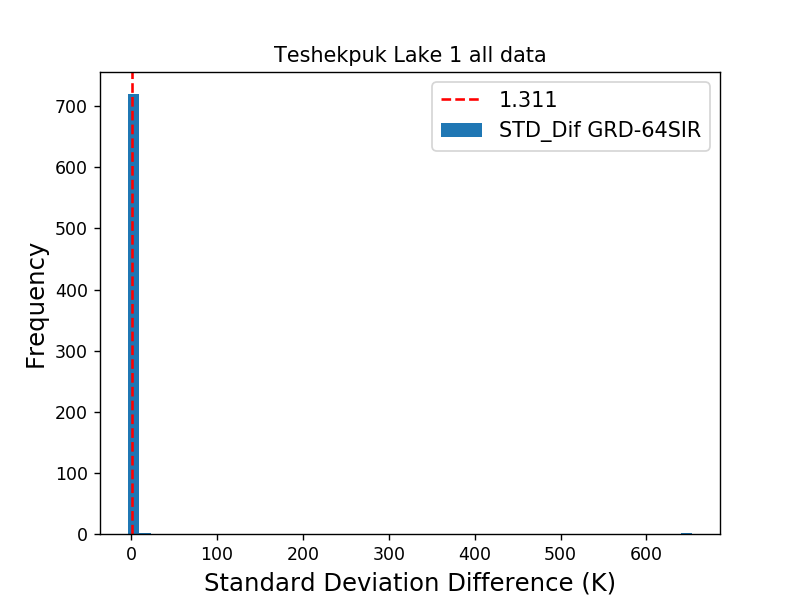

In [42]:
# histogram of the difference between GRD_Tb_std variable and the computed std of the 64 SIR pixels
#plt.close()
fig,ax=plt.subplots()
values=Tb_sd_diff.dropna().values
ax.hist(values,bins=50, label='STD_Dif GRD-64SIR')
ax.set_title(Site+' all data')
ax.axvline(x=Tb_sd_diff.mean(), color='red', linestyle='dashed', label=Tb_sd_diff.mean().round(3))
ax.legend(fontsize=12)
ax.set_ylabel('Frequency',fontsize=14)
ax.set_xlabel('Standard Deviation Difference (K)',fontsize=14)
plt.savefig('../../jmr_plots/testing2.png')

<IPython.core.display.Javascript object>


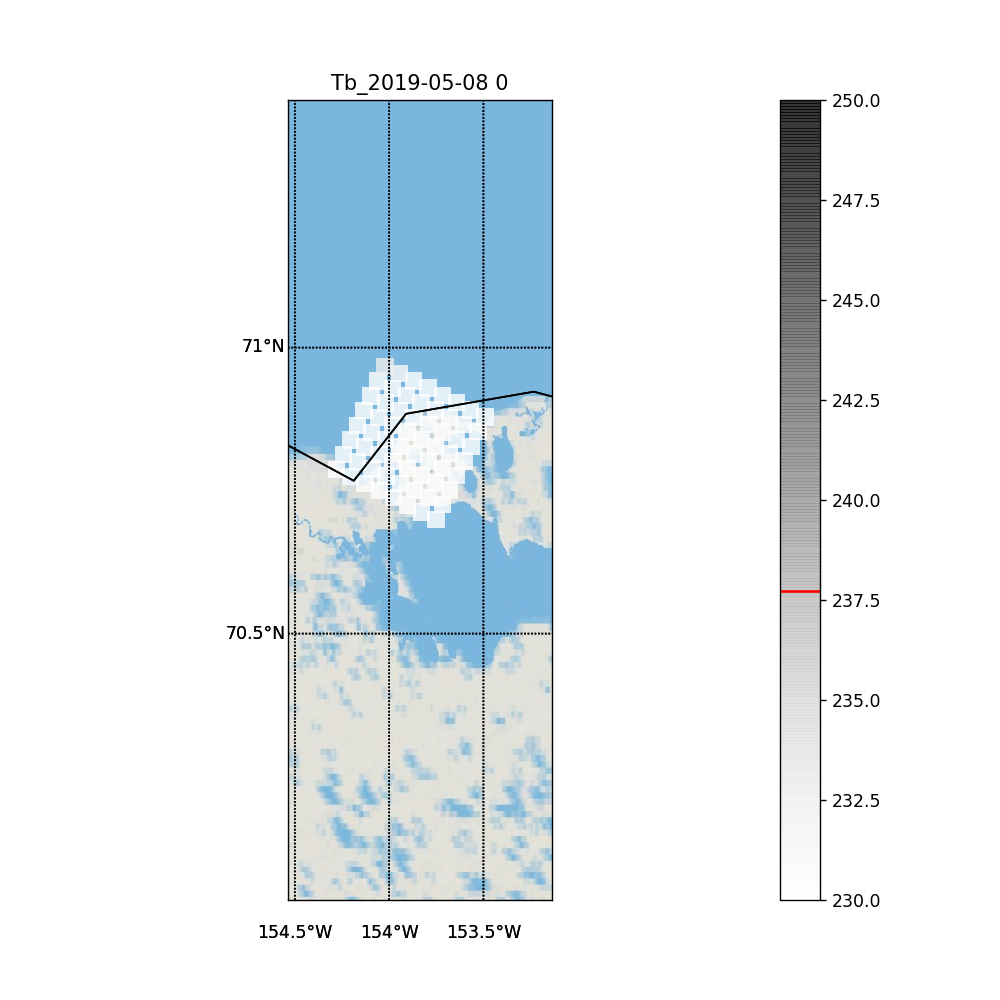

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-17202905.453341793,11076173.816537216,-17047058.166231215,11548446.09584224&bboxSR=3857&imageSR=3857&size=1500,4545&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-17202905.453341793,11076173.816537216,-17047058.166231215,11548446.09584224&bboxSR=3857&imageSR=3857&size=1500,4545&dpi=96&format=png32&transparent=true&f=image


In [44]:
# Plot Tb map
date='2019-05-08' # specify date of interest
obs=0 # 0 for morning or 1 for evening observation

# load Tb_std_dev array
array=Tb_frame.loc[date].values
array=array[obs]
GRD=Tb_frame_GRD.loc[date].values
GRD=GRD[obs]

fig = plt.figure(figsize=(8,8))
# create figure and axes instances
#fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#ax = fig.add_subplot(121)
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=lon_start,lat_0=lat_start,lat_ts=90.,\
            llcrnrlat=(lat_start-.7),urcrnrlat=(lat_start+.7),\
            llcrnrlon=(lon_start-.7),urcrnrlon=(lon_start+.7),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

x,y=m(pixel_lons, pixel_lats)
#m.plot(x,y, 'bs', markersize=11, markeredgewidth=1, alpha=0.2)
m.scatter(x,y,c=array, s=100, marker='s',lw=0, cmap='Greys', alpha=.8)  # cmap='Blues'
#x,y=m(ISAlons,ISAlats)
#m.plot(x,y,'ro',markersize=2,markeredgewidth=0.0)
plt.title('Tb_'+date+' '+str(obs))

# plot a red line on colorbar for the MOD for the GRD pixel
cbar=plt.colorbar()
cbar.ax.hlines(cbar.norm(GRD), 0, 1, color='red') 
plt.clim(230,250)  #color bar limits

plt.show()
#plt.savefig('../jmr_plots/PnOWL_amsre_TB_040107-1.png')
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=lon_start,lat_0=lat_start,lat_ts=90.,\
            llcrnrlat=(lat_start-.7),urcrnrlat=(lat_start+.7),\
            llcrnrlon=(lon_start-.7),urcrnrlon=(lon_start+.7),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

#x,y=m(pixel_lons, pixel_lats)
#m.plot(x,y, 'bs', markersize=11, markeredgewidth=1, alpha=0.2)
#m.scatter(x,y,c=MOD_DOY_array, s=150, marker='s',lw=0,cmap='Blues', alpha=.0)
#x,y=m(ISAlons,ISAlats)
#m.plot(x,y,'ro',markersize=2,markeredgewidth=0.0)
#plt.title('Tb - std dev')
#plt.colorbar()
plt.show()
plt.savefig('../../jmr_plots/testIceland_Katla_f18_05082019AM.png')


In [45]:
GRD


array([220.22], dtype=float32)

In [47]:
# returns the average Jan-Feb DAV for each pixel for each year - SIR
Jan_Feb_DAV=Winter_DAV(CETB_SIR, cal_date, cal_year, Years, rows_cols_env)
Jan_Feb_DAV

KeyError: "None of [Timestamp('2019-01-01 06:00:00'), Timestamp('2019-01-01 18:00:00'), Timestamp('2019-01-02 06:00:00'), Timestamp('2019-01-02 18:00:00'), Timestamp('2019-01-03 06:00:00'), Timestamp('2019-01-03 18:00:00'), Timestamp('2019-01-04 06:00:00'), Timestamp('2019-01-04 18:00:00'), Timestamp('2019-01-05 06:00:00'), Timestamp('2019-01-05 18:00:00'), Timestamp('2019-01-06 06:00:00'), Timestamp('2019-01-06 18:00:00'), Timestamp('2019-01-07 06:00:00'), Timestamp('2019-01-07 18:00:00'), Timestamp('2019-01-08 06:00:00'), Timestamp('2019-01-08 18:00:00'), Timestamp('2019-01-09 06:00:00'), Timestamp('2019-01-09 18:00:00'), Timestamp('2019-01-10 06:00:00'), Timestamp('2019-01-10 18:00:00'), Timestamp('2019-01-11 06:00:00'), Timestamp('2019-01-11 18:00:00'), Timestamp('2019-01-12 06:00:00'), Timestamp('2019-01-12 18:00:00'), Timestamp('2019-01-13 06:00:00'), Timestamp('2019-01-13 18:00:00'), Timestamp('2019-01-14 06:00:00'), Timestamp('2019-01-14 18:00:00'), Timestamp('2019-01-15 06:00:00'), Timestamp('2019-01-15 18:00:00'), Timestamp('2019-01-16 06:00:00'), Timestamp('2019-01-16 18:00:00'), Timestamp('2019-01-17 06:00:00'), Timestamp('2019-01-17 18:00:00'), Timestamp('2019-01-18 06:00:00'), Timestamp('2019-01-18 18:00:00'), Timestamp('2019-01-19 06:00:00'), Timestamp('2019-01-19 18:00:00'), Timestamp('2019-01-20 06:00:00'), Timestamp('2019-01-20 18:00:00'), Timestamp('2019-01-21 06:00:00'), Timestamp('2019-01-21 18:00:00'), Timestamp('2019-01-22 06:00:00'), Timestamp('2019-01-22 18:00:00'), Timestamp('2019-01-23 06:00:00'), Timestamp('2019-01-23 18:00:00'), Timestamp('2019-01-24 06:00:00'), Timestamp('2019-01-24 18:00:00'), Timestamp('2019-01-25 06:00:00'), Timestamp('2019-01-25 18:00:00'), Timestamp('2019-01-26 06:00:00'), Timestamp('2019-01-26 18:00:00'), Timestamp('2019-01-27 06:00:00'), Timestamp('2019-01-27 18:00:00'), Timestamp('2019-01-28 06:00:00'), Timestamp('2019-01-28 18:00:00'), Timestamp('2019-01-29 06:00:00'), Timestamp('2019-01-29 18:00:00'), Timestamp('2019-01-30 06:00:00'), Timestamp('2019-01-30 18:00:00'), Timestamp('2019-01-31 06:00:00'), Timestamp('2019-01-31 18:00:00'), Timestamp('2019-02-01 06:00:00'), Timestamp('2019-02-01 18:00:00'), Timestamp('2019-02-02 06:00:00'), Timestamp('2019-02-02 18:00:00'), Timestamp('2019-02-03 06:00:00'), Timestamp('2019-02-03 18:00:00'), Timestamp('2019-02-04 06:00:00'), Timestamp('2019-02-04 18:00:00'), Timestamp('2019-02-05 06:00:00'), Timestamp('2019-02-05 18:00:00'), Timestamp('2019-02-06 06:00:00'), Timestamp('2019-02-06 18:00:00'), Timestamp('2019-02-07 06:00:00'), Timestamp('2019-02-07 18:00:00'), Timestamp('2019-02-08 06:00:00'), Timestamp('2019-02-08 18:00:00'), Timestamp('2019-02-09 06:00:00'), Timestamp('2019-02-09 18:00:00'), Timestamp('2019-02-10 06:00:00'), Timestamp('2019-02-10 18:00:00'), Timestamp('2019-02-11 06:00:00'), Timestamp('2019-02-11 18:00:00'), Timestamp('2019-02-12 06:00:00'), Timestamp('2019-02-12 18:00:00'), Timestamp('2019-02-13 06:00:00'), Timestamp('2019-02-13 18:00:00'), Timestamp('2019-02-14 06:00:00'), Timestamp('2019-02-14 18:00:00'), Timestamp('2019-02-15 06:00:00'), Timestamp('2019-02-15 18:00:00'), Timestamp('2019-02-16 06:00:00'), Timestamp('2019-02-16 18:00:00'), Timestamp('2019-02-17 06:00:00'), Timestamp('2019-02-17 18:00:00'), Timestamp('2019-02-18 06:00:00'), Timestamp('2019-02-18 18:00:00'), Timestamp('2019-02-19 06:00:00'), Timestamp('2019-02-19 18:00:00'), Timestamp('2019-02-20 06:00:00'), Timestamp('2019-02-20 18:00:00'), Timestamp('2019-02-21 06:00:00'), Timestamp('2019-02-21 18:00:00'), Timestamp('2019-02-22 06:00:00'), Timestamp('2019-02-22 18:00:00'), Timestamp('2019-02-23 06:00:00'), Timestamp('2019-02-23 18:00:00'), Timestamp('2019-02-24 06:00:00'), Timestamp('2019-02-24 18:00:00'), Timestamp('2019-02-25 06:00:00'), Timestamp('2019-02-25 18:00:00'), Timestamp('2019-02-26 06:00:00'), Timestamp('2019-02-26 18:00:00'), Timestamp('2019-02-27 06:00:00'), Timestamp('2019-02-27 18:00:00'), Timestamp('2019-02-28 06:00:00'), Timestamp('2019-02-28 18:00:00'), Timestamp('2019-03-01 06:00:00'), Timestamp('2019-03-01 18:00:00'), Timestamp('2019-03-02 06:00:00'), Timestamp('2019-03-02 18:00:00'), Timestamp('2019-03-03 06:00:00'), Timestamp('2019-03-03 18:00:00'), Timestamp('2019-03-04 06:00:00'), Timestamp('2019-03-04 18:00:00'), Timestamp('2019-03-05 06:00:00'), Timestamp('2019-03-05 18:00:00'), Timestamp('2019-03-06 06:00:00'), Timestamp('2019-03-06 18:00:00'), Timestamp('2019-03-07 06:00:00'), Timestamp('2019-03-07 18:00:00'), Timestamp('2019-03-08 06:00:00'), Timestamp('2019-03-08 18:00:00'), Timestamp('2019-03-09 06:00:00'), Timestamp('2019-03-09 18:00:00'), Timestamp('2019-03-10 06:00:00'), Timestamp('2019-03-10 18:00:00'), Timestamp('2019-03-11 06:00:00'), Timestamp('2019-03-11 18:00:00'), Timestamp('2019-03-12 06:00:00'), Timestamp('2019-03-12 18:00:00'), Timestamp('2019-03-13 06:00:00'), Timestamp('2019-03-13 18:00:00'), Timestamp('2019-03-14 06:00:00'), Timestamp('2019-03-14 18:00:00'), Timestamp('2019-03-15 06:00:00'), Timestamp('2019-03-15 18:00:00'), Timestamp('2019-03-16 06:00:00'), Timestamp('2019-03-16 18:00:00'), Timestamp('2019-03-17 06:00:00'), Timestamp('2019-03-17 18:00:00'), Timestamp('2019-03-18 06:00:00'), Timestamp('2019-03-18 18:00:00'), Timestamp('2019-03-19 06:00:00'), Timestamp('2019-03-19 18:00:00'), Timestamp('2019-03-20 06:00:00'), Timestamp('2019-03-20 18:00:00'), Timestamp('2019-03-21 06:00:00'), Timestamp('2019-03-21 18:00:00'), Timestamp('2019-03-22 06:00:00'), Timestamp('2019-03-22 18:00:00'), Timestamp('2019-03-23 06:00:00'), Timestamp('2019-03-23 18:00:00'), Timestamp('2019-03-24 06:00:00'), Timestamp('2019-03-24 18:00:00'), Timestamp('2019-03-25 06:00:00'), Timestamp('2019-03-25 18:00:00'), Timestamp('2019-03-26 06:00:00'), Timestamp('2019-03-26 18:00:00'), Timestamp('2019-03-27 06:00:00'), Timestamp('2019-03-27 18:00:00'), Timestamp('2019-03-28 06:00:00'), Timestamp('2019-03-28 18:00:00'), Timestamp('2019-03-29 06:00:00'), Timestamp('2019-03-29 18:00:00'), Timestamp('2019-03-30 06:00:00'), Timestamp('2019-03-30 18:00:00'), Timestamp('2019-03-31 06:00:00'), Timestamp('2019-03-31 18:00:00'), Timestamp('2019-04-01 06:00:00'), Timestamp('2019-04-01 18:00:00'), Timestamp('2019-04-02 06:00:00'), Timestamp('2019-04-02 18:00:00'), Timestamp('2019-04-03 06:00:00'), Timestamp('2019-04-03 18:00:00'), Timestamp('2019-04-04 06:00:00'), Timestamp('2019-04-04 18:00:00'), Timestamp('2019-04-05 06:00:00'), Timestamp('2019-04-05 18:00:00'), Timestamp('2019-04-06 06:00:00'), Timestamp('2019-04-06 18:00:00'), Timestamp('2019-04-07 06:00:00'), Timestamp('2019-04-07 18:00:00'), Timestamp('2019-04-08 06:00:00'), Timestamp('2019-04-08 18:00:00'), Timestamp('2019-04-09 06:00:00'), Timestamp('2019-04-09 18:00:00'), Timestamp('2019-04-10 06:00:00'), Timestamp('2019-04-10 18:00:00'), Timestamp('2019-04-11 06:00:00'), Timestamp('2019-04-11 18:00:00'), Timestamp('2019-04-12 06:00:00'), Timestamp('2019-04-12 18:00:00'), Timestamp('2019-04-13 06:00:00'), Timestamp('2019-04-13 18:00:00'), Timestamp('2019-04-14 06:00:00'), Timestamp('2019-04-14 18:00:00'), Timestamp('2019-04-15 06:00:00'), Timestamp('2019-04-15 18:00:00'), Timestamp('2019-04-16 06:00:00'), Timestamp('2019-04-16 18:00:00'), Timestamp('2019-04-17 06:00:00'), Timestamp('2019-04-17 18:00:00'), Timestamp('2019-04-18 06:00:00'), Timestamp('2019-04-18 18:00:00'), Timestamp('2019-04-19 06:00:00'), Timestamp('2019-04-19 18:00:00'), Timestamp('2019-04-20 06:00:00'), Timestamp('2019-04-20 18:00:00'), Timestamp('2019-04-21 06:00:00'), Timestamp('2019-04-21 18:00:00'), Timestamp('2019-04-22 06:00:00'), Timestamp('2019-04-22 18:00:00'), Timestamp('2019-04-23 06:00:00'), Timestamp('2019-04-23 18:00:00'), Timestamp('2019-04-24 06:00:00'), Timestamp('2019-04-24 18:00:00'), Timestamp('2019-04-25 06:00:00'), Timestamp('2019-04-25 18:00:00'), Timestamp('2019-04-26 06:00:00'), Timestamp('2019-04-26 18:00:00'), Timestamp('2019-04-27 06:00:00'), Timestamp('2019-04-27 18:00:00'), Timestamp('2019-04-28 06:00:00'), Timestamp('2019-04-28 18:00:00'), Timestamp('2019-04-29 06:00:00'), Timestamp('2019-04-29 18:00:00'), Timestamp('2019-04-30 06:00:00'), Timestamp('2019-04-30 18:00:00'), Timestamp('2019-05-01 06:00:00'), Timestamp('2019-05-01 18:00:00'), Timestamp('2019-05-02 06:00:00'), Timestamp('2019-05-02 18:00:00'), Timestamp('2019-05-03 06:00:00'), Timestamp('2019-05-03 18:00:00'), Timestamp('2019-05-04 06:00:00'), Timestamp('2019-05-04 18:00:00'), Timestamp('2019-05-05 06:00:00'), Timestamp('2019-05-05 18:00:00'), Timestamp('2019-05-06 06:00:00'), Timestamp('2019-05-06 18:00:00'), Timestamp('2019-05-07 06:00:00'), Timestamp('2019-05-07 18:00:00'), Timestamp('2019-05-08 06:00:00'), Timestamp('2019-05-08 18:00:00'), Timestamp('2019-05-09 06:00:00'), Timestamp('2019-05-09 18:00:00'), Timestamp('2019-05-10 06:00:00'), Timestamp('2019-05-10 18:00:00'), Timestamp('2019-05-11 06:00:00'), Timestamp('2019-05-11 18:00:00'), Timestamp('2019-05-12 06:00:00'), Timestamp('2019-05-12 18:00:00'), Timestamp('2019-05-13 06:00:00'), Timestamp('2019-05-13 18:00:00'), Timestamp('2019-05-14 06:00:00'), Timestamp('2019-05-14 18:00:00'), Timestamp('2019-05-15 06:00:00'), Timestamp('2019-05-15 18:00:00'), Timestamp('2019-05-16 06:00:00'), Timestamp('2019-05-16 18:00:00'), Timestamp('2019-05-17 06:00:00'), Timestamp('2019-05-17 18:00:00'), Timestamp('2019-05-18 06:00:00'), Timestamp('2019-05-18 18:00:00'), Timestamp('2019-05-19 06:00:00'), Timestamp('2019-05-19 18:00:00'), Timestamp('2019-05-20 06:00:00'), Timestamp('2019-05-20 18:00:00'), Timestamp('2019-05-21 06:00:00'), Timestamp('2019-05-21 18:00:00'), Timestamp('2019-05-22 06:00:00'), Timestamp('2019-05-22 18:00:00'), Timestamp('2019-05-23 06:00:00'), Timestamp('2019-05-23 18:00:00'), Timestamp('2019-05-24 06:00:00'), Timestamp('2019-05-24 18:00:00'), Timestamp('2019-05-25 06:00:00'), Timestamp('2019-05-25 18:00:00'), Timestamp('2019-05-26 06:00:00'), Timestamp('2019-05-26 18:00:00'), Timestamp('2019-05-27 06:00:00'), Timestamp('2019-05-27 18:00:00'), Timestamp('2019-05-28 06:00:00'), Timestamp('2019-05-28 18:00:00'), Timestamp('2019-05-29 06:00:00'), Timestamp('2019-05-29 18:00:00'), Timestamp('2019-05-30 06:00:00'), Timestamp('2019-05-30 18:00:00'), Timestamp('2019-05-31 06:00:00'), Timestamp('2019-05-31 18:00:00'), Timestamp('2019-06-01 06:00:00'), Timestamp('2019-06-01 18:00:00'), Timestamp('2019-06-02 06:00:00'), Timestamp('2019-06-02 18:00:00'), Timestamp('2019-06-03 06:00:00'), Timestamp('2019-06-03 18:00:00'), Timestamp('2019-06-04 06:00:00'), Timestamp('2019-06-04 18:00:00'), Timestamp('2019-06-05 06:00:00'), Timestamp('2019-06-05 18:00:00'), Timestamp('2019-06-06 06:00:00'), Timestamp('2019-06-06 18:00:00'), Timestamp('2019-06-07 06:00:00'), Timestamp('2019-06-07 18:00:00'), Timestamp('2019-06-08 06:00:00'), Timestamp('2019-06-08 18:00:00'), Timestamp('2019-06-09 06:00:00'), Timestamp('2019-06-09 18:00:00'), Timestamp('2019-06-10 06:00:00'), Timestamp('2019-06-10 18:00:00'), Timestamp('2019-06-11 06:00:00'), Timestamp('2019-06-11 18:00:00'), Timestamp('2019-06-12 06:00:00'), Timestamp('2019-06-12 18:00:00'), Timestamp('2019-06-13 06:00:00'), Timestamp('2019-06-13 18:00:00'), Timestamp('2019-06-14 06:00:00'), Timestamp('2019-06-14 18:00:00'), Timestamp('2019-06-15 06:00:00'), Timestamp('2019-06-15 18:00:00'), Timestamp('2019-06-16 06:00:00'), Timestamp('2019-06-16 18:00:00'), Timestamp('2019-06-17 06:00:00'), Timestamp('2019-06-17 18:00:00'), Timestamp('2019-06-18 06:00:00'), Timestamp('2019-06-18 18:00:00'), Timestamp('2019-06-19 06:00:00'), Timestamp('2019-06-19 18:00:00'), Timestamp('2019-06-20 06:00:00'), Timestamp('2019-06-20 18:00:00'), Timestamp('2019-06-21 06:00:00'), Timestamp('2019-06-21 18:00:00'), Timestamp('2019-06-22 06:00:00'), Timestamp('2019-06-22 18:00:00'), Timestamp('2019-06-23 06:00:00'), Timestamp('2019-06-23 18:00:00'), Timestamp('2019-06-24 06:00:00'), Timestamp('2019-06-24 18:00:00'), Timestamp('2019-06-25 06:00:00'), Timestamp('2019-06-25 18:00:00'), Timestamp('2019-06-26 06:00:00'), Timestamp('2019-06-26 18:00:00'), Timestamp('2019-06-27 06:00:00'), Timestamp('2019-06-27 18:00:00'), Timestamp('2019-06-28 06:00:00'), Timestamp('2019-06-28 18:00:00'), Timestamp('2019-06-29 06:00:00'), Timestamp('2019-06-29 18:00:00'), Timestamp('2019-06-30 06:00:00'), Timestamp('2019-06-30 18:00:00'), Timestamp('2019-07-01 06:00:00'), Timestamp('2019-07-01 18:00:00'), Timestamp('2019-07-02 06:00:00'), Timestamp('2019-07-02 18:00:00'), Timestamp('2019-07-03 06:00:00'), Timestamp('2019-07-03 18:00:00'), Timestamp('2019-07-04 06:00:00'), Timestamp('2019-07-04 18:00:00'), Timestamp('2019-07-05 06:00:00'), Timestamp('2019-07-05 18:00:00'), Timestamp('2019-07-06 06:00:00'), Timestamp('2019-07-06 18:00:00'), Timestamp('2019-07-07 06:00:00'), Timestamp('2019-07-07 18:00:00'), Timestamp('2019-07-08 06:00:00'), Timestamp('2019-07-08 18:00:00'), Timestamp('2019-07-09 06:00:00'), Timestamp('2019-07-09 18:00:00'), Timestamp('2019-07-10 06:00:00'), Timestamp('2019-07-10 18:00:00'), Timestamp('2019-07-11 06:00:00'), Timestamp('2019-07-11 18:00:00'), Timestamp('2019-07-12 06:00:00'), Timestamp('2019-07-12 18:00:00'), Timestamp('2019-07-13 06:00:00'), Timestamp('2019-07-13 18:00:00'), Timestamp('2019-07-14 06:00:00'), Timestamp('2019-07-14 18:00:00'), Timestamp('2019-07-15 06:00:00'), Timestamp('2019-07-15 18:00:00'), Timestamp('2019-07-16 06:00:00'), Timestamp('2019-07-16 18:00:00'), Timestamp('2019-07-17 06:00:00'), Timestamp('2019-07-17 18:00:00'), Timestamp('2019-07-18 06:00:00'), Timestamp('2019-07-18 18:00:00'), Timestamp('2019-07-19 06:00:00'), Timestamp('2019-07-19 18:00:00'), Timestamp('2019-07-20 06:00:00'), Timestamp('2019-07-20 18:00:00'), Timestamp('2019-07-21 06:00:00'), Timestamp('2019-07-21 18:00:00'), Timestamp('2019-07-22 06:00:00'), Timestamp('2019-07-22 18:00:00'), Timestamp('2019-07-23 06:00:00'), Timestamp('2019-07-23 18:00:00'), Timestamp('2019-07-24 06:00:00'), Timestamp('2019-07-24 18:00:00'), Timestamp('2019-07-25 06:00:00'), Timestamp('2019-07-25 18:00:00'), Timestamp('2019-07-26 06:00:00'), Timestamp('2019-07-26 18:00:00'), Timestamp('2019-07-27 06:00:00'), Timestamp('2019-07-27 18:00:00'), Timestamp('2019-07-28 06:00:00'), Timestamp('2019-07-28 18:00:00'), Timestamp('2019-07-29 06:00:00'), Timestamp('2019-07-29 18:00:00'), Timestamp('2019-07-30 06:00:00'), Timestamp('2019-07-30 18:00:00'), Timestamp('2019-07-31 06:00:00'), Timestamp('2019-07-31 18:00:00'), Timestamp('2019-08-01 06:00:00'), Timestamp('2019-08-01 18:00:00'), Timestamp('2019-08-02 06:00:00'), Timestamp('2019-08-02 18:00:00'), Timestamp('2019-08-03 06:00:00'), Timestamp('2019-08-03 18:00:00'), Timestamp('2019-08-04 06:00:00'), Timestamp('2019-08-04 18:00:00'), Timestamp('2019-08-05 06:00:00'), Timestamp('2019-08-05 18:00:00'), Timestamp('2019-08-06 06:00:00'), Timestamp('2019-08-06 18:00:00'), Timestamp('2019-08-07 06:00:00'), Timestamp('2019-08-07 18:00:00'), Timestamp('2019-08-08 06:00:00'), Timestamp('2019-08-08 18:00:00'), Timestamp('2019-08-09 06:00:00'), Timestamp('2019-08-09 18:00:00'), Timestamp('2019-08-10 06:00:00'), Timestamp('2019-08-10 18:00:00'), Timestamp('2019-08-11 06:00:00'), Timestamp('2019-08-11 18:00:00'), Timestamp('2019-08-12 06:00:00'), Timestamp('2019-08-12 18:00:00'), Timestamp('2019-08-13 06:00:00'), Timestamp('2019-08-13 18:00:00'), Timestamp('2019-08-14 06:00:00'), Timestamp('2019-08-14 18:00:00'), Timestamp('2019-08-15 06:00:00'), Timestamp('2019-08-15 18:00:00'), Timestamp('2019-08-16 06:00:00'), Timestamp('2019-08-16 18:00:00'), Timestamp('2019-08-17 06:00:00'), Timestamp('2019-08-17 18:00:00'), Timestamp('2019-08-18 06:00:00'), Timestamp('2019-08-18 18:00:00'), Timestamp('2019-08-19 06:00:00'), Timestamp('2019-08-19 18:00:00'), Timestamp('2019-08-20 06:00:00'), Timestamp('2019-08-20 18:00:00'), Timestamp('2019-08-21 06:00:00'), Timestamp('2019-08-21 18:00:00'), Timestamp('2019-08-22 06:00:00'), Timestamp('2019-08-22 18:00:00'), Timestamp('2019-08-23 06:00:00'), Timestamp('2019-08-23 18:00:00'), Timestamp('2019-08-24 06:00:00'), Timestamp('2019-08-24 18:00:00'), Timestamp('2019-08-25 06:00:00'), Timestamp('2019-08-25 18:00:00'), Timestamp('2019-08-26 06:00:00'), Timestamp('2019-08-26 18:00:00'), Timestamp('2019-08-27 06:00:00'), Timestamp('2019-08-27 18:00:00'), Timestamp('2019-08-28 06:00:00'), Timestamp('2019-08-28 18:00:00'), Timestamp('2019-08-29 06:00:00'), Timestamp('2019-08-29 18:00:00'), Timestamp('2019-08-30 06:00:00'), Timestamp('2019-08-30 18:00:00'), Timestamp('2019-08-31 06:00:00'), Timestamp('2019-08-31 18:00:00'), Timestamp('2019-09-01 06:00:00'), Timestamp('2019-09-01 18:00:00'), Timestamp('2019-09-02 06:00:00'), Timestamp('2019-09-02 18:00:00'), Timestamp('2019-09-03 06:00:00'), Timestamp('2019-09-03 18:00:00'), Timestamp('2019-09-04 06:00:00'), Timestamp('2019-09-04 18:00:00'), Timestamp('2019-09-05 06:00:00'), Timestamp('2019-09-05 18:00:00'), Timestamp('2019-09-06 06:00:00'), Timestamp('2019-09-06 18:00:00'), Timestamp('2019-09-07 06:00:00'), Timestamp('2019-09-07 18:00:00'), Timestamp('2019-09-08 06:00:00'), Timestamp('2019-09-08 18:00:00'), Timestamp('2019-09-09 06:00:00'), Timestamp('2019-09-09 18:00:00'), Timestamp('2019-09-10 06:00:00'), Timestamp('2019-09-10 18:00:00'), Timestamp('2019-09-11 06:00:00'), Timestamp('2019-09-11 18:00:00'), Timestamp('2019-09-12 06:00:00'), Timestamp('2019-09-12 18:00:00'), Timestamp('2019-09-13 06:00:00'), Timestamp('2019-09-13 18:00:00'), Timestamp('2019-09-14 06:00:00'), Timestamp('2019-09-14 18:00:00'), Timestamp('2019-09-15 06:00:00'), Timestamp('2019-09-15 18:00:00'), Timestamp('2019-09-16 06:00:00'), Timestamp('2019-09-16 18:00:00'), Timestamp('2019-09-17 06:00:00'), Timestamp('2019-09-17 18:00:00'), Timestamp('2019-09-18 06:00:00'), Timestamp('2019-09-18 18:00:00'), Timestamp('2019-09-19 06:00:00'), Timestamp('2019-09-19 18:00:00'), Timestamp('2019-09-20 06:00:00'), Timestamp('2019-09-20 18:00:00'), Timestamp('2019-09-21 06:00:00'), Timestamp('2019-09-21 18:00:00'), Timestamp('2019-09-22 06:00:00'), Timestamp('2019-09-22 18:00:00'), Timestamp('2019-09-23 06:00:00'), Timestamp('2019-09-23 18:00:00'), Timestamp('2019-09-24 06:00:00'), Timestamp('2019-09-24 18:00:00'), Timestamp('2019-09-25 06:00:00'), Timestamp('2019-09-25 18:00:00'), Timestamp('2019-09-26 06:00:00'), Timestamp('2019-09-26 18:00:00'), Timestamp('2019-09-27 06:00:00'), Timestamp('2019-09-27 18:00:00'), Timestamp('2019-09-28 06:00:00'), Timestamp('2019-09-28 18:00:00'), Timestamp('2019-09-29 06:00:00'), Timestamp('2019-09-29 18:00:00'), Timestamp('2019-09-30 06:00:00'), Timestamp('2019-09-30 18:00:00'), Timestamp('2019-10-01 06:00:00'), Timestamp('2019-10-01 18:00:00'), Timestamp('2019-10-02 06:00:00'), Timestamp('2019-10-02 18:00:00'), Timestamp('2019-10-03 06:00:00'), Timestamp('2019-10-03 18:00:00'), Timestamp('2019-10-04 06:00:00'), Timestamp('2019-10-04 18:00:00'), Timestamp('2019-10-05 06:00:00'), Timestamp('2019-10-05 18:00:00'), Timestamp('2019-10-06 06:00:00'), Timestamp('2019-10-06 18:00:00'), Timestamp('2019-10-07 06:00:00'), Timestamp('2019-10-07 18:00:00'), Timestamp('2019-10-08 06:00:00'), Timestamp('2019-10-08 18:00:00'), Timestamp('2019-10-09 06:00:00'), Timestamp('2019-10-09 18:00:00'), Timestamp('2019-10-10 06:00:00'), Timestamp('2019-10-10 18:00:00'), Timestamp('2019-10-11 06:00:00'), Timestamp('2019-10-11 18:00:00'), Timestamp('2019-10-12 06:00:00'), Timestamp('2019-10-12 18:00:00'), Timestamp('2019-10-13 06:00:00'), Timestamp('2019-10-13 18:00:00'), Timestamp('2019-10-14 06:00:00'), Timestamp('2019-10-14 18:00:00'), Timestamp('2019-10-15 06:00:00'), Timestamp('2019-10-15 18:00:00'), Timestamp('2019-10-16 06:00:00'), Timestamp('2019-10-16 18:00:00'), Timestamp('2019-10-17 06:00:00'), Timestamp('2019-10-17 18:00:00'), Timestamp('2019-10-18 06:00:00'), Timestamp('2019-10-18 18:00:00'), Timestamp('2019-10-19 06:00:00'), Timestamp('2019-10-19 18:00:00'), Timestamp('2019-10-20 06:00:00'), Timestamp('2019-10-20 18:00:00'), Timestamp('2019-10-21 06:00:00'), Timestamp('2019-10-21 18:00:00'), Timestamp('2019-10-22 06:00:00'), Timestamp('2019-10-22 18:00:00'), Timestamp('2019-10-23 06:00:00'), Timestamp('2019-10-23 18:00:00'), Timestamp('2019-10-24 06:00:00'), Timestamp('2019-10-24 18:00:00'), Timestamp('2019-10-25 06:00:00'), Timestamp('2019-10-25 18:00:00'), Timestamp('2019-10-26 06:00:00'), Timestamp('2019-10-26 18:00:00'), Timestamp('2019-10-27 06:00:00'), Timestamp('2019-10-27 18:00:00'), Timestamp('2019-10-28 06:00:00'), Timestamp('2019-10-28 18:00:00'), Timestamp('2019-10-29 06:00:00'), Timestamp('2019-10-29 18:00:00'), Timestamp('2019-10-30 06:00:00'), Timestamp('2019-10-30 18:00:00'), Timestamp('2019-10-31 06:00:00'), Timestamp('2019-10-31 18:00:00'), Timestamp('2019-11-01 06:00:00'), Timestamp('2019-11-01 18:00:00'), Timestamp('2019-11-02 06:00:00'), Timestamp('2019-11-02 18:00:00'), Timestamp('2019-11-03 06:00:00'), Timestamp('2019-11-03 18:00:00'), Timestamp('2019-11-04 06:00:00'), Timestamp('2019-11-04 18:00:00'), Timestamp('2019-11-05 06:00:00'), Timestamp('2019-11-05 18:00:00'), Timestamp('2019-11-06 06:00:00'), Timestamp('2019-11-06 18:00:00'), Timestamp('2019-11-07 06:00:00'), Timestamp('2019-11-07 18:00:00'), Timestamp('2019-11-08 06:00:00'), Timestamp('2019-11-08 18:00:00'), Timestamp('2019-11-09 06:00:00'), Timestamp('2019-11-09 18:00:00'), Timestamp('2019-11-10 06:00:00'), Timestamp('2019-11-10 18:00:00'), Timestamp('2019-11-11 06:00:00'), Timestamp('2019-11-11 18:00:00'), Timestamp('2019-11-12 06:00:00'), Timestamp('2019-11-12 18:00:00'), Timestamp('2019-11-13 06:00:00'), Timestamp('2019-11-13 18:00:00'), Timestamp('2019-11-14 06:00:00'), Timestamp('2019-11-14 18:00:00'), Timestamp('2019-11-15 06:00:00'), Timestamp('2019-11-15 18:00:00'), Timestamp('2019-11-16 06:00:00'), Timestamp('2019-11-16 18:00:00'), Timestamp('2019-11-17 06:00:00'), Timestamp('2019-11-17 18:00:00'), Timestamp('2019-11-18 06:00:00'), Timestamp('2019-11-18 18:00:00'), Timestamp('2019-11-19 06:00:00'), Timestamp('2019-11-19 18:00:00'), Timestamp('2019-11-20 06:00:00'), Timestamp('2019-11-20 18:00:00'), Timestamp('2019-11-21 06:00:00'), Timestamp('2019-11-21 18:00:00'), Timestamp('2019-11-22 06:00:00'), Timestamp('2019-11-22 18:00:00'), Timestamp('2019-11-23 06:00:00'), Timestamp('2019-11-23 18:00:00'), Timestamp('2019-11-24 06:00:00'), Timestamp('2019-11-24 18:00:00'), Timestamp('2019-11-25 06:00:00'), Timestamp('2019-11-25 18:00:00'), Timestamp('2019-11-26 06:00:00'), Timestamp('2019-11-26 18:00:00'), Timestamp('2019-11-27 06:00:00'), Timestamp('2019-11-27 18:00:00'), Timestamp('2019-11-28 06:00:00'), Timestamp('2019-11-28 18:00:00'), Timestamp('2019-11-29 06:00:00'), Timestamp('2019-11-29 18:00:00'), Timestamp('2019-11-30 06:00:00'), Timestamp('2019-11-30 18:00:00'), Timestamp('2019-12-01 06:00:00'), Timestamp('2019-12-01 18:00:00'), Timestamp('2019-12-02 06:00:00'), Timestamp('2019-12-02 18:00:00'), Timestamp('2019-12-03 06:00:00'), Timestamp('2019-12-03 18:00:00'), Timestamp('2019-12-04 06:00:00'), Timestamp('2019-12-04 18:00:00'), Timestamp('2019-12-05 06:00:00'), Timestamp('2019-12-05 18:00:00'), Timestamp('2019-12-06 06:00:00'), Timestamp('2019-12-06 18:00:00'), Timestamp('2019-12-07 06:00:00'), Timestamp('2019-12-07 18:00:00'), Timestamp('2019-12-08 06:00:00'), Timestamp('2019-12-08 18:00:00'), Timestamp('2019-12-09 06:00:00'), Timestamp('2019-12-09 18:00:00'), Timestamp('2019-12-10 06:00:00'), Timestamp('2019-12-10 18:00:00'), Timestamp('2019-12-11 06:00:00'), Timestamp('2019-12-11 18:00:00'), Timestamp('2019-12-12 06:00:00'), Timestamp('2019-12-12 18:00:00'), Timestamp('2019-12-13 06:00:00'), Timestamp('2019-12-13 18:00:00'), Timestamp('2019-12-14 06:00:00'), Timestamp('2019-12-14 18:00:00'), Timestamp('2019-12-15 06:00:00'), Timestamp('2019-12-15 18:00:00'), Timestamp('2019-12-16 06:00:00'), Timestamp('2019-12-16 18:00:00'), Timestamp('2019-12-17 06:00:00'), Timestamp('2019-12-17 18:00:00'), Timestamp('2019-12-18 06:00:00'), Timestamp('2019-12-18 18:00:00'), Timestamp('2019-12-19 06:00:00'), Timestamp('2019-12-19 18:00:00'), Timestamp('2019-12-20 06:00:00'), Timestamp('2019-12-20 18:00:00'), Timestamp('2019-12-21 06:00:00'), Timestamp('2019-12-21 18:00:00'), Timestamp('2019-12-22 06:00:00'), Timestamp('2019-12-22 18:00:00'), Timestamp('2019-12-23 06:00:00'), Timestamp('2019-12-23 18:00:00'), Timestamp('2019-12-24 06:00:00'), Timestamp('2019-12-24 18:00:00'), Timestamp('2019-12-25 06:00:00'), Timestamp('2019-12-25 18:00:00'), Timestamp('2019-12-26 06:00:00'), Timestamp('2019-12-26 18:00:00'), Timestamp('2019-12-27 06:00:00'), Timestamp('2019-12-27 18:00:00'), Timestamp('2019-12-28 06:00:00'), Timestamp('2019-12-28 18:00:00'), Timestamp('2019-12-29 06:00:00'), Timestamp('2019-12-29 18:00:00'), Timestamp('2019-12-30 06:00:00'), Timestamp('2019-12-30 18:00:00'), Timestamp('2019-12-31 06:00:00'), Timestamp('2019-12-31 18:00:00')] are in the columns"

In [48]:
Jan_Feb_DAV_avg=Jan_Feb_DAV.mean(axis=0)
Jan_Feb_DAV_avg=Jan_Feb_DAV_avg.values
#Jan_Feb_DAV_avg=np.round(Jan_Feb_DAV_avg)
Jan_Feb_DAV_avg

NameError: name 'Jan_Feb_DAV' is not defined

In [49]:
# returns the average Jan-Feb DAV for the GRD pixel for each year
Jan_Feb_DAV_GRD=Winter_DAV(CETB_GRD, cal_date, cal_year, Years, rows_cols_GRD)
Jan_Feb_DAV_GRD

KeyError: "None of [Timestamp('2019-01-01 06:00:00'), Timestamp('2019-01-01 18:00:00'), Timestamp('2019-01-02 06:00:00'), Timestamp('2019-01-02 18:00:00'), Timestamp('2019-01-03 06:00:00'), Timestamp('2019-01-03 18:00:00'), Timestamp('2019-01-04 06:00:00'), Timestamp('2019-01-04 18:00:00'), Timestamp('2019-01-05 06:00:00'), Timestamp('2019-01-05 18:00:00'), Timestamp('2019-01-06 06:00:00'), Timestamp('2019-01-06 18:00:00'), Timestamp('2019-01-07 06:00:00'), Timestamp('2019-01-07 18:00:00'), Timestamp('2019-01-08 06:00:00'), Timestamp('2019-01-08 18:00:00'), Timestamp('2019-01-09 06:00:00'), Timestamp('2019-01-09 18:00:00'), Timestamp('2019-01-10 06:00:00'), Timestamp('2019-01-10 18:00:00'), Timestamp('2019-01-11 06:00:00'), Timestamp('2019-01-11 18:00:00'), Timestamp('2019-01-12 06:00:00'), Timestamp('2019-01-12 18:00:00'), Timestamp('2019-01-13 06:00:00'), Timestamp('2019-01-13 18:00:00'), Timestamp('2019-01-14 06:00:00'), Timestamp('2019-01-14 18:00:00'), Timestamp('2019-01-15 06:00:00'), Timestamp('2019-01-15 18:00:00'), Timestamp('2019-01-16 06:00:00'), Timestamp('2019-01-16 18:00:00'), Timestamp('2019-01-17 06:00:00'), Timestamp('2019-01-17 18:00:00'), Timestamp('2019-01-18 06:00:00'), Timestamp('2019-01-18 18:00:00'), Timestamp('2019-01-19 06:00:00'), Timestamp('2019-01-19 18:00:00'), Timestamp('2019-01-20 06:00:00'), Timestamp('2019-01-20 18:00:00'), Timestamp('2019-01-21 06:00:00'), Timestamp('2019-01-21 18:00:00'), Timestamp('2019-01-22 06:00:00'), Timestamp('2019-01-22 18:00:00'), Timestamp('2019-01-23 06:00:00'), Timestamp('2019-01-23 18:00:00'), Timestamp('2019-01-24 06:00:00'), Timestamp('2019-01-24 18:00:00'), Timestamp('2019-01-25 06:00:00'), Timestamp('2019-01-25 18:00:00'), Timestamp('2019-01-26 06:00:00'), Timestamp('2019-01-26 18:00:00'), Timestamp('2019-01-27 06:00:00'), Timestamp('2019-01-27 18:00:00'), Timestamp('2019-01-28 06:00:00'), Timestamp('2019-01-28 18:00:00'), Timestamp('2019-01-29 06:00:00'), Timestamp('2019-01-29 18:00:00'), Timestamp('2019-01-30 06:00:00'), Timestamp('2019-01-30 18:00:00'), Timestamp('2019-01-31 06:00:00'), Timestamp('2019-01-31 18:00:00'), Timestamp('2019-02-01 06:00:00'), Timestamp('2019-02-01 18:00:00'), Timestamp('2019-02-02 06:00:00'), Timestamp('2019-02-02 18:00:00'), Timestamp('2019-02-03 06:00:00'), Timestamp('2019-02-03 18:00:00'), Timestamp('2019-02-04 06:00:00'), Timestamp('2019-02-04 18:00:00'), Timestamp('2019-02-05 06:00:00'), Timestamp('2019-02-05 18:00:00'), Timestamp('2019-02-06 06:00:00'), Timestamp('2019-02-06 18:00:00'), Timestamp('2019-02-07 06:00:00'), Timestamp('2019-02-07 18:00:00'), Timestamp('2019-02-08 06:00:00'), Timestamp('2019-02-08 18:00:00'), Timestamp('2019-02-09 06:00:00'), Timestamp('2019-02-09 18:00:00'), Timestamp('2019-02-10 06:00:00'), Timestamp('2019-02-10 18:00:00'), Timestamp('2019-02-11 06:00:00'), Timestamp('2019-02-11 18:00:00'), Timestamp('2019-02-12 06:00:00'), Timestamp('2019-02-12 18:00:00'), Timestamp('2019-02-13 06:00:00'), Timestamp('2019-02-13 18:00:00'), Timestamp('2019-02-14 06:00:00'), Timestamp('2019-02-14 18:00:00'), Timestamp('2019-02-15 06:00:00'), Timestamp('2019-02-15 18:00:00'), Timestamp('2019-02-16 06:00:00'), Timestamp('2019-02-16 18:00:00'), Timestamp('2019-02-17 06:00:00'), Timestamp('2019-02-17 18:00:00'), Timestamp('2019-02-18 06:00:00'), Timestamp('2019-02-18 18:00:00'), Timestamp('2019-02-19 06:00:00'), Timestamp('2019-02-19 18:00:00'), Timestamp('2019-02-20 06:00:00'), Timestamp('2019-02-20 18:00:00'), Timestamp('2019-02-21 06:00:00'), Timestamp('2019-02-21 18:00:00'), Timestamp('2019-02-22 06:00:00'), Timestamp('2019-02-22 18:00:00'), Timestamp('2019-02-23 06:00:00'), Timestamp('2019-02-23 18:00:00'), Timestamp('2019-02-24 06:00:00'), Timestamp('2019-02-24 18:00:00'), Timestamp('2019-02-25 06:00:00'), Timestamp('2019-02-25 18:00:00'), Timestamp('2019-02-26 06:00:00'), Timestamp('2019-02-26 18:00:00'), Timestamp('2019-02-27 06:00:00'), Timestamp('2019-02-27 18:00:00'), Timestamp('2019-02-28 06:00:00'), Timestamp('2019-02-28 18:00:00'), Timestamp('2019-03-01 06:00:00'), Timestamp('2019-03-01 18:00:00'), Timestamp('2019-03-02 06:00:00'), Timestamp('2019-03-02 18:00:00'), Timestamp('2019-03-03 06:00:00'), Timestamp('2019-03-03 18:00:00'), Timestamp('2019-03-04 06:00:00'), Timestamp('2019-03-04 18:00:00'), Timestamp('2019-03-05 06:00:00'), Timestamp('2019-03-05 18:00:00'), Timestamp('2019-03-06 06:00:00'), Timestamp('2019-03-06 18:00:00'), Timestamp('2019-03-07 06:00:00'), Timestamp('2019-03-07 18:00:00'), Timestamp('2019-03-08 06:00:00'), Timestamp('2019-03-08 18:00:00'), Timestamp('2019-03-09 06:00:00'), Timestamp('2019-03-09 18:00:00'), Timestamp('2019-03-10 06:00:00'), Timestamp('2019-03-10 18:00:00'), Timestamp('2019-03-11 06:00:00'), Timestamp('2019-03-11 18:00:00'), Timestamp('2019-03-12 06:00:00'), Timestamp('2019-03-12 18:00:00'), Timestamp('2019-03-13 06:00:00'), Timestamp('2019-03-13 18:00:00'), Timestamp('2019-03-14 06:00:00'), Timestamp('2019-03-14 18:00:00'), Timestamp('2019-03-15 06:00:00'), Timestamp('2019-03-15 18:00:00'), Timestamp('2019-03-16 06:00:00'), Timestamp('2019-03-16 18:00:00'), Timestamp('2019-03-17 06:00:00'), Timestamp('2019-03-17 18:00:00'), Timestamp('2019-03-18 06:00:00'), Timestamp('2019-03-18 18:00:00'), Timestamp('2019-03-19 06:00:00'), Timestamp('2019-03-19 18:00:00'), Timestamp('2019-03-20 06:00:00'), Timestamp('2019-03-20 18:00:00'), Timestamp('2019-03-21 06:00:00'), Timestamp('2019-03-21 18:00:00'), Timestamp('2019-03-22 06:00:00'), Timestamp('2019-03-22 18:00:00'), Timestamp('2019-03-23 06:00:00'), Timestamp('2019-03-23 18:00:00'), Timestamp('2019-03-24 06:00:00'), Timestamp('2019-03-24 18:00:00'), Timestamp('2019-03-25 06:00:00'), Timestamp('2019-03-25 18:00:00'), Timestamp('2019-03-26 06:00:00'), Timestamp('2019-03-26 18:00:00'), Timestamp('2019-03-27 06:00:00'), Timestamp('2019-03-27 18:00:00'), Timestamp('2019-03-28 06:00:00'), Timestamp('2019-03-28 18:00:00'), Timestamp('2019-03-29 06:00:00'), Timestamp('2019-03-29 18:00:00'), Timestamp('2019-03-30 06:00:00'), Timestamp('2019-03-30 18:00:00'), Timestamp('2019-03-31 06:00:00'), Timestamp('2019-03-31 18:00:00'), Timestamp('2019-04-01 06:00:00'), Timestamp('2019-04-01 18:00:00'), Timestamp('2019-04-02 06:00:00'), Timestamp('2019-04-02 18:00:00'), Timestamp('2019-04-03 06:00:00'), Timestamp('2019-04-03 18:00:00'), Timestamp('2019-04-04 06:00:00'), Timestamp('2019-04-04 18:00:00'), Timestamp('2019-04-05 06:00:00'), Timestamp('2019-04-05 18:00:00'), Timestamp('2019-04-06 06:00:00'), Timestamp('2019-04-06 18:00:00'), Timestamp('2019-04-07 06:00:00'), Timestamp('2019-04-07 18:00:00'), Timestamp('2019-04-08 06:00:00'), Timestamp('2019-04-08 18:00:00'), Timestamp('2019-04-09 06:00:00'), Timestamp('2019-04-09 18:00:00'), Timestamp('2019-04-10 06:00:00'), Timestamp('2019-04-10 18:00:00'), Timestamp('2019-04-11 06:00:00'), Timestamp('2019-04-11 18:00:00'), Timestamp('2019-04-12 06:00:00'), Timestamp('2019-04-12 18:00:00'), Timestamp('2019-04-13 06:00:00'), Timestamp('2019-04-13 18:00:00'), Timestamp('2019-04-14 06:00:00'), Timestamp('2019-04-14 18:00:00'), Timestamp('2019-04-15 06:00:00'), Timestamp('2019-04-15 18:00:00'), Timestamp('2019-04-16 06:00:00'), Timestamp('2019-04-16 18:00:00'), Timestamp('2019-04-17 06:00:00'), Timestamp('2019-04-17 18:00:00'), Timestamp('2019-04-18 06:00:00'), Timestamp('2019-04-18 18:00:00'), Timestamp('2019-04-19 06:00:00'), Timestamp('2019-04-19 18:00:00'), Timestamp('2019-04-20 06:00:00'), Timestamp('2019-04-20 18:00:00'), Timestamp('2019-04-21 06:00:00'), Timestamp('2019-04-21 18:00:00'), Timestamp('2019-04-22 06:00:00'), Timestamp('2019-04-22 18:00:00'), Timestamp('2019-04-23 06:00:00'), Timestamp('2019-04-23 18:00:00'), Timestamp('2019-04-24 06:00:00'), Timestamp('2019-04-24 18:00:00'), Timestamp('2019-04-25 06:00:00'), Timestamp('2019-04-25 18:00:00'), Timestamp('2019-04-26 06:00:00'), Timestamp('2019-04-26 18:00:00'), Timestamp('2019-04-27 06:00:00'), Timestamp('2019-04-27 18:00:00'), Timestamp('2019-04-28 06:00:00'), Timestamp('2019-04-28 18:00:00'), Timestamp('2019-04-29 06:00:00'), Timestamp('2019-04-29 18:00:00'), Timestamp('2019-04-30 06:00:00'), Timestamp('2019-04-30 18:00:00'), Timestamp('2019-05-01 06:00:00'), Timestamp('2019-05-01 18:00:00'), Timestamp('2019-05-02 06:00:00'), Timestamp('2019-05-02 18:00:00'), Timestamp('2019-05-03 06:00:00'), Timestamp('2019-05-03 18:00:00'), Timestamp('2019-05-04 06:00:00'), Timestamp('2019-05-04 18:00:00'), Timestamp('2019-05-05 06:00:00'), Timestamp('2019-05-05 18:00:00'), Timestamp('2019-05-06 06:00:00'), Timestamp('2019-05-06 18:00:00'), Timestamp('2019-05-07 06:00:00'), Timestamp('2019-05-07 18:00:00'), Timestamp('2019-05-08 06:00:00'), Timestamp('2019-05-08 18:00:00'), Timestamp('2019-05-09 06:00:00'), Timestamp('2019-05-09 18:00:00'), Timestamp('2019-05-10 06:00:00'), Timestamp('2019-05-10 18:00:00'), Timestamp('2019-05-11 06:00:00'), Timestamp('2019-05-11 18:00:00'), Timestamp('2019-05-12 06:00:00'), Timestamp('2019-05-12 18:00:00'), Timestamp('2019-05-13 06:00:00'), Timestamp('2019-05-13 18:00:00'), Timestamp('2019-05-14 06:00:00'), Timestamp('2019-05-14 18:00:00'), Timestamp('2019-05-15 06:00:00'), Timestamp('2019-05-15 18:00:00'), Timestamp('2019-05-16 06:00:00'), Timestamp('2019-05-16 18:00:00'), Timestamp('2019-05-17 06:00:00'), Timestamp('2019-05-17 18:00:00'), Timestamp('2019-05-18 06:00:00'), Timestamp('2019-05-18 18:00:00'), Timestamp('2019-05-19 06:00:00'), Timestamp('2019-05-19 18:00:00'), Timestamp('2019-05-20 06:00:00'), Timestamp('2019-05-20 18:00:00'), Timestamp('2019-05-21 06:00:00'), Timestamp('2019-05-21 18:00:00'), Timestamp('2019-05-22 06:00:00'), Timestamp('2019-05-22 18:00:00'), Timestamp('2019-05-23 06:00:00'), Timestamp('2019-05-23 18:00:00'), Timestamp('2019-05-24 06:00:00'), Timestamp('2019-05-24 18:00:00'), Timestamp('2019-05-25 06:00:00'), Timestamp('2019-05-25 18:00:00'), Timestamp('2019-05-26 06:00:00'), Timestamp('2019-05-26 18:00:00'), Timestamp('2019-05-27 06:00:00'), Timestamp('2019-05-27 18:00:00'), Timestamp('2019-05-28 06:00:00'), Timestamp('2019-05-28 18:00:00'), Timestamp('2019-05-29 06:00:00'), Timestamp('2019-05-29 18:00:00'), Timestamp('2019-05-30 06:00:00'), Timestamp('2019-05-30 18:00:00'), Timestamp('2019-05-31 06:00:00'), Timestamp('2019-05-31 18:00:00'), Timestamp('2019-06-01 06:00:00'), Timestamp('2019-06-01 18:00:00'), Timestamp('2019-06-02 06:00:00'), Timestamp('2019-06-02 18:00:00'), Timestamp('2019-06-03 06:00:00'), Timestamp('2019-06-03 18:00:00'), Timestamp('2019-06-04 06:00:00'), Timestamp('2019-06-04 18:00:00'), Timestamp('2019-06-05 06:00:00'), Timestamp('2019-06-05 18:00:00'), Timestamp('2019-06-06 06:00:00'), Timestamp('2019-06-06 18:00:00'), Timestamp('2019-06-07 06:00:00'), Timestamp('2019-06-07 18:00:00'), Timestamp('2019-06-08 06:00:00'), Timestamp('2019-06-08 18:00:00'), Timestamp('2019-06-09 06:00:00'), Timestamp('2019-06-09 18:00:00'), Timestamp('2019-06-10 06:00:00'), Timestamp('2019-06-10 18:00:00'), Timestamp('2019-06-11 06:00:00'), Timestamp('2019-06-11 18:00:00'), Timestamp('2019-06-12 06:00:00'), Timestamp('2019-06-12 18:00:00'), Timestamp('2019-06-13 06:00:00'), Timestamp('2019-06-13 18:00:00'), Timestamp('2019-06-14 06:00:00'), Timestamp('2019-06-14 18:00:00'), Timestamp('2019-06-15 06:00:00'), Timestamp('2019-06-15 18:00:00'), Timestamp('2019-06-16 06:00:00'), Timestamp('2019-06-16 18:00:00'), Timestamp('2019-06-17 06:00:00'), Timestamp('2019-06-17 18:00:00'), Timestamp('2019-06-18 06:00:00'), Timestamp('2019-06-18 18:00:00'), Timestamp('2019-06-19 06:00:00'), Timestamp('2019-06-19 18:00:00'), Timestamp('2019-06-20 06:00:00'), Timestamp('2019-06-20 18:00:00'), Timestamp('2019-06-21 06:00:00'), Timestamp('2019-06-21 18:00:00'), Timestamp('2019-06-22 06:00:00'), Timestamp('2019-06-22 18:00:00'), Timestamp('2019-06-23 06:00:00'), Timestamp('2019-06-23 18:00:00'), Timestamp('2019-06-24 06:00:00'), Timestamp('2019-06-24 18:00:00'), Timestamp('2019-06-25 06:00:00'), Timestamp('2019-06-25 18:00:00'), Timestamp('2019-06-26 06:00:00'), Timestamp('2019-06-26 18:00:00'), Timestamp('2019-06-27 06:00:00'), Timestamp('2019-06-27 18:00:00'), Timestamp('2019-06-28 06:00:00'), Timestamp('2019-06-28 18:00:00'), Timestamp('2019-06-29 06:00:00'), Timestamp('2019-06-29 18:00:00'), Timestamp('2019-06-30 06:00:00'), Timestamp('2019-06-30 18:00:00'), Timestamp('2019-07-01 06:00:00'), Timestamp('2019-07-01 18:00:00'), Timestamp('2019-07-02 06:00:00'), Timestamp('2019-07-02 18:00:00'), Timestamp('2019-07-03 06:00:00'), Timestamp('2019-07-03 18:00:00'), Timestamp('2019-07-04 06:00:00'), Timestamp('2019-07-04 18:00:00'), Timestamp('2019-07-05 06:00:00'), Timestamp('2019-07-05 18:00:00'), Timestamp('2019-07-06 06:00:00'), Timestamp('2019-07-06 18:00:00'), Timestamp('2019-07-07 06:00:00'), Timestamp('2019-07-07 18:00:00'), Timestamp('2019-07-08 06:00:00'), Timestamp('2019-07-08 18:00:00'), Timestamp('2019-07-09 06:00:00'), Timestamp('2019-07-09 18:00:00'), Timestamp('2019-07-10 06:00:00'), Timestamp('2019-07-10 18:00:00'), Timestamp('2019-07-11 06:00:00'), Timestamp('2019-07-11 18:00:00'), Timestamp('2019-07-12 06:00:00'), Timestamp('2019-07-12 18:00:00'), Timestamp('2019-07-13 06:00:00'), Timestamp('2019-07-13 18:00:00'), Timestamp('2019-07-14 06:00:00'), Timestamp('2019-07-14 18:00:00'), Timestamp('2019-07-15 06:00:00'), Timestamp('2019-07-15 18:00:00'), Timestamp('2019-07-16 06:00:00'), Timestamp('2019-07-16 18:00:00'), Timestamp('2019-07-17 06:00:00'), Timestamp('2019-07-17 18:00:00'), Timestamp('2019-07-18 06:00:00'), Timestamp('2019-07-18 18:00:00'), Timestamp('2019-07-19 06:00:00'), Timestamp('2019-07-19 18:00:00'), Timestamp('2019-07-20 06:00:00'), Timestamp('2019-07-20 18:00:00'), Timestamp('2019-07-21 06:00:00'), Timestamp('2019-07-21 18:00:00'), Timestamp('2019-07-22 06:00:00'), Timestamp('2019-07-22 18:00:00'), Timestamp('2019-07-23 06:00:00'), Timestamp('2019-07-23 18:00:00'), Timestamp('2019-07-24 06:00:00'), Timestamp('2019-07-24 18:00:00'), Timestamp('2019-07-25 06:00:00'), Timestamp('2019-07-25 18:00:00'), Timestamp('2019-07-26 06:00:00'), Timestamp('2019-07-26 18:00:00'), Timestamp('2019-07-27 06:00:00'), Timestamp('2019-07-27 18:00:00'), Timestamp('2019-07-28 06:00:00'), Timestamp('2019-07-28 18:00:00'), Timestamp('2019-07-29 06:00:00'), Timestamp('2019-07-29 18:00:00'), Timestamp('2019-07-30 06:00:00'), Timestamp('2019-07-30 18:00:00'), Timestamp('2019-07-31 06:00:00'), Timestamp('2019-07-31 18:00:00'), Timestamp('2019-08-01 06:00:00'), Timestamp('2019-08-01 18:00:00'), Timestamp('2019-08-02 06:00:00'), Timestamp('2019-08-02 18:00:00'), Timestamp('2019-08-03 06:00:00'), Timestamp('2019-08-03 18:00:00'), Timestamp('2019-08-04 06:00:00'), Timestamp('2019-08-04 18:00:00'), Timestamp('2019-08-05 06:00:00'), Timestamp('2019-08-05 18:00:00'), Timestamp('2019-08-06 06:00:00'), Timestamp('2019-08-06 18:00:00'), Timestamp('2019-08-07 06:00:00'), Timestamp('2019-08-07 18:00:00'), Timestamp('2019-08-08 06:00:00'), Timestamp('2019-08-08 18:00:00'), Timestamp('2019-08-09 06:00:00'), Timestamp('2019-08-09 18:00:00'), Timestamp('2019-08-10 06:00:00'), Timestamp('2019-08-10 18:00:00'), Timestamp('2019-08-11 06:00:00'), Timestamp('2019-08-11 18:00:00'), Timestamp('2019-08-12 06:00:00'), Timestamp('2019-08-12 18:00:00'), Timestamp('2019-08-13 06:00:00'), Timestamp('2019-08-13 18:00:00'), Timestamp('2019-08-14 06:00:00'), Timestamp('2019-08-14 18:00:00'), Timestamp('2019-08-15 06:00:00'), Timestamp('2019-08-15 18:00:00'), Timestamp('2019-08-16 06:00:00'), Timestamp('2019-08-16 18:00:00'), Timestamp('2019-08-17 06:00:00'), Timestamp('2019-08-17 18:00:00'), Timestamp('2019-08-18 06:00:00'), Timestamp('2019-08-18 18:00:00'), Timestamp('2019-08-19 06:00:00'), Timestamp('2019-08-19 18:00:00'), Timestamp('2019-08-20 06:00:00'), Timestamp('2019-08-20 18:00:00'), Timestamp('2019-08-21 06:00:00'), Timestamp('2019-08-21 18:00:00'), Timestamp('2019-08-22 06:00:00'), Timestamp('2019-08-22 18:00:00'), Timestamp('2019-08-23 06:00:00'), Timestamp('2019-08-23 18:00:00'), Timestamp('2019-08-24 06:00:00'), Timestamp('2019-08-24 18:00:00'), Timestamp('2019-08-25 06:00:00'), Timestamp('2019-08-25 18:00:00'), Timestamp('2019-08-26 06:00:00'), Timestamp('2019-08-26 18:00:00'), Timestamp('2019-08-27 06:00:00'), Timestamp('2019-08-27 18:00:00'), Timestamp('2019-08-28 06:00:00'), Timestamp('2019-08-28 18:00:00'), Timestamp('2019-08-29 06:00:00'), Timestamp('2019-08-29 18:00:00'), Timestamp('2019-08-30 06:00:00'), Timestamp('2019-08-30 18:00:00'), Timestamp('2019-08-31 06:00:00'), Timestamp('2019-08-31 18:00:00'), Timestamp('2019-09-01 06:00:00'), Timestamp('2019-09-01 18:00:00'), Timestamp('2019-09-02 06:00:00'), Timestamp('2019-09-02 18:00:00'), Timestamp('2019-09-03 06:00:00'), Timestamp('2019-09-03 18:00:00'), Timestamp('2019-09-04 06:00:00'), Timestamp('2019-09-04 18:00:00'), Timestamp('2019-09-05 06:00:00'), Timestamp('2019-09-05 18:00:00'), Timestamp('2019-09-06 06:00:00'), Timestamp('2019-09-06 18:00:00'), Timestamp('2019-09-07 06:00:00'), Timestamp('2019-09-07 18:00:00'), Timestamp('2019-09-08 06:00:00'), Timestamp('2019-09-08 18:00:00'), Timestamp('2019-09-09 06:00:00'), Timestamp('2019-09-09 18:00:00'), Timestamp('2019-09-10 06:00:00'), Timestamp('2019-09-10 18:00:00'), Timestamp('2019-09-11 06:00:00'), Timestamp('2019-09-11 18:00:00'), Timestamp('2019-09-12 06:00:00'), Timestamp('2019-09-12 18:00:00'), Timestamp('2019-09-13 06:00:00'), Timestamp('2019-09-13 18:00:00'), Timestamp('2019-09-14 06:00:00'), Timestamp('2019-09-14 18:00:00'), Timestamp('2019-09-15 06:00:00'), Timestamp('2019-09-15 18:00:00'), Timestamp('2019-09-16 06:00:00'), Timestamp('2019-09-16 18:00:00'), Timestamp('2019-09-17 06:00:00'), Timestamp('2019-09-17 18:00:00'), Timestamp('2019-09-18 06:00:00'), Timestamp('2019-09-18 18:00:00'), Timestamp('2019-09-19 06:00:00'), Timestamp('2019-09-19 18:00:00'), Timestamp('2019-09-20 06:00:00'), Timestamp('2019-09-20 18:00:00'), Timestamp('2019-09-21 06:00:00'), Timestamp('2019-09-21 18:00:00'), Timestamp('2019-09-22 06:00:00'), Timestamp('2019-09-22 18:00:00'), Timestamp('2019-09-23 06:00:00'), Timestamp('2019-09-23 18:00:00'), Timestamp('2019-09-24 06:00:00'), Timestamp('2019-09-24 18:00:00'), Timestamp('2019-09-25 06:00:00'), Timestamp('2019-09-25 18:00:00'), Timestamp('2019-09-26 06:00:00'), Timestamp('2019-09-26 18:00:00'), Timestamp('2019-09-27 06:00:00'), Timestamp('2019-09-27 18:00:00'), Timestamp('2019-09-28 06:00:00'), Timestamp('2019-09-28 18:00:00'), Timestamp('2019-09-29 06:00:00'), Timestamp('2019-09-29 18:00:00'), Timestamp('2019-09-30 06:00:00'), Timestamp('2019-09-30 18:00:00'), Timestamp('2019-10-01 06:00:00'), Timestamp('2019-10-01 18:00:00'), Timestamp('2019-10-02 06:00:00'), Timestamp('2019-10-02 18:00:00'), Timestamp('2019-10-03 06:00:00'), Timestamp('2019-10-03 18:00:00'), Timestamp('2019-10-04 06:00:00'), Timestamp('2019-10-04 18:00:00'), Timestamp('2019-10-05 06:00:00'), Timestamp('2019-10-05 18:00:00'), Timestamp('2019-10-06 06:00:00'), Timestamp('2019-10-06 18:00:00'), Timestamp('2019-10-07 06:00:00'), Timestamp('2019-10-07 18:00:00'), Timestamp('2019-10-08 06:00:00'), Timestamp('2019-10-08 18:00:00'), Timestamp('2019-10-09 06:00:00'), Timestamp('2019-10-09 18:00:00'), Timestamp('2019-10-10 06:00:00'), Timestamp('2019-10-10 18:00:00'), Timestamp('2019-10-11 06:00:00'), Timestamp('2019-10-11 18:00:00'), Timestamp('2019-10-12 06:00:00'), Timestamp('2019-10-12 18:00:00'), Timestamp('2019-10-13 06:00:00'), Timestamp('2019-10-13 18:00:00'), Timestamp('2019-10-14 06:00:00'), Timestamp('2019-10-14 18:00:00'), Timestamp('2019-10-15 06:00:00'), Timestamp('2019-10-15 18:00:00'), Timestamp('2019-10-16 06:00:00'), Timestamp('2019-10-16 18:00:00'), Timestamp('2019-10-17 06:00:00'), Timestamp('2019-10-17 18:00:00'), Timestamp('2019-10-18 06:00:00'), Timestamp('2019-10-18 18:00:00'), Timestamp('2019-10-19 06:00:00'), Timestamp('2019-10-19 18:00:00'), Timestamp('2019-10-20 06:00:00'), Timestamp('2019-10-20 18:00:00'), Timestamp('2019-10-21 06:00:00'), Timestamp('2019-10-21 18:00:00'), Timestamp('2019-10-22 06:00:00'), Timestamp('2019-10-22 18:00:00'), Timestamp('2019-10-23 06:00:00'), Timestamp('2019-10-23 18:00:00'), Timestamp('2019-10-24 06:00:00'), Timestamp('2019-10-24 18:00:00'), Timestamp('2019-10-25 06:00:00'), Timestamp('2019-10-25 18:00:00'), Timestamp('2019-10-26 06:00:00'), Timestamp('2019-10-26 18:00:00'), Timestamp('2019-10-27 06:00:00'), Timestamp('2019-10-27 18:00:00'), Timestamp('2019-10-28 06:00:00'), Timestamp('2019-10-28 18:00:00'), Timestamp('2019-10-29 06:00:00'), Timestamp('2019-10-29 18:00:00'), Timestamp('2019-10-30 06:00:00'), Timestamp('2019-10-30 18:00:00'), Timestamp('2019-10-31 06:00:00'), Timestamp('2019-10-31 18:00:00'), Timestamp('2019-11-01 06:00:00'), Timestamp('2019-11-01 18:00:00'), Timestamp('2019-11-02 06:00:00'), Timestamp('2019-11-02 18:00:00'), Timestamp('2019-11-03 06:00:00'), Timestamp('2019-11-03 18:00:00'), Timestamp('2019-11-04 06:00:00'), Timestamp('2019-11-04 18:00:00'), Timestamp('2019-11-05 06:00:00'), Timestamp('2019-11-05 18:00:00'), Timestamp('2019-11-06 06:00:00'), Timestamp('2019-11-06 18:00:00'), Timestamp('2019-11-07 06:00:00'), Timestamp('2019-11-07 18:00:00'), Timestamp('2019-11-08 06:00:00'), Timestamp('2019-11-08 18:00:00'), Timestamp('2019-11-09 06:00:00'), Timestamp('2019-11-09 18:00:00'), Timestamp('2019-11-10 06:00:00'), Timestamp('2019-11-10 18:00:00'), Timestamp('2019-11-11 06:00:00'), Timestamp('2019-11-11 18:00:00'), Timestamp('2019-11-12 06:00:00'), Timestamp('2019-11-12 18:00:00'), Timestamp('2019-11-13 06:00:00'), Timestamp('2019-11-13 18:00:00'), Timestamp('2019-11-14 06:00:00'), Timestamp('2019-11-14 18:00:00'), Timestamp('2019-11-15 06:00:00'), Timestamp('2019-11-15 18:00:00'), Timestamp('2019-11-16 06:00:00'), Timestamp('2019-11-16 18:00:00'), Timestamp('2019-11-17 06:00:00'), Timestamp('2019-11-17 18:00:00'), Timestamp('2019-11-18 06:00:00'), Timestamp('2019-11-18 18:00:00'), Timestamp('2019-11-19 06:00:00'), Timestamp('2019-11-19 18:00:00'), Timestamp('2019-11-20 06:00:00'), Timestamp('2019-11-20 18:00:00'), Timestamp('2019-11-21 06:00:00'), Timestamp('2019-11-21 18:00:00'), Timestamp('2019-11-22 06:00:00'), Timestamp('2019-11-22 18:00:00'), Timestamp('2019-11-23 06:00:00'), Timestamp('2019-11-23 18:00:00'), Timestamp('2019-11-24 06:00:00'), Timestamp('2019-11-24 18:00:00'), Timestamp('2019-11-25 06:00:00'), Timestamp('2019-11-25 18:00:00'), Timestamp('2019-11-26 06:00:00'), Timestamp('2019-11-26 18:00:00'), Timestamp('2019-11-27 06:00:00'), Timestamp('2019-11-27 18:00:00'), Timestamp('2019-11-28 06:00:00'), Timestamp('2019-11-28 18:00:00'), Timestamp('2019-11-29 06:00:00'), Timestamp('2019-11-29 18:00:00'), Timestamp('2019-11-30 06:00:00'), Timestamp('2019-11-30 18:00:00'), Timestamp('2019-12-01 06:00:00'), Timestamp('2019-12-01 18:00:00'), Timestamp('2019-12-02 06:00:00'), Timestamp('2019-12-02 18:00:00'), Timestamp('2019-12-03 06:00:00'), Timestamp('2019-12-03 18:00:00'), Timestamp('2019-12-04 06:00:00'), Timestamp('2019-12-04 18:00:00'), Timestamp('2019-12-05 06:00:00'), Timestamp('2019-12-05 18:00:00'), Timestamp('2019-12-06 06:00:00'), Timestamp('2019-12-06 18:00:00'), Timestamp('2019-12-07 06:00:00'), Timestamp('2019-12-07 18:00:00'), Timestamp('2019-12-08 06:00:00'), Timestamp('2019-12-08 18:00:00'), Timestamp('2019-12-09 06:00:00'), Timestamp('2019-12-09 18:00:00'), Timestamp('2019-12-10 06:00:00'), Timestamp('2019-12-10 18:00:00'), Timestamp('2019-12-11 06:00:00'), Timestamp('2019-12-11 18:00:00'), Timestamp('2019-12-12 06:00:00'), Timestamp('2019-12-12 18:00:00'), Timestamp('2019-12-13 06:00:00'), Timestamp('2019-12-13 18:00:00'), Timestamp('2019-12-14 06:00:00'), Timestamp('2019-12-14 18:00:00'), Timestamp('2019-12-15 06:00:00'), Timestamp('2019-12-15 18:00:00'), Timestamp('2019-12-16 06:00:00'), Timestamp('2019-12-16 18:00:00'), Timestamp('2019-12-17 06:00:00'), Timestamp('2019-12-17 18:00:00'), Timestamp('2019-12-18 06:00:00'), Timestamp('2019-12-18 18:00:00'), Timestamp('2019-12-19 06:00:00'), Timestamp('2019-12-19 18:00:00'), Timestamp('2019-12-20 06:00:00'), Timestamp('2019-12-20 18:00:00'), Timestamp('2019-12-21 06:00:00'), Timestamp('2019-12-21 18:00:00'), Timestamp('2019-12-22 06:00:00'), Timestamp('2019-12-22 18:00:00'), Timestamp('2019-12-23 06:00:00'), Timestamp('2019-12-23 18:00:00'), Timestamp('2019-12-24 06:00:00'), Timestamp('2019-12-24 18:00:00'), Timestamp('2019-12-25 06:00:00'), Timestamp('2019-12-25 18:00:00'), Timestamp('2019-12-26 06:00:00'), Timestamp('2019-12-26 18:00:00'), Timestamp('2019-12-27 06:00:00'), Timestamp('2019-12-27 18:00:00'), Timestamp('2019-12-28 06:00:00'), Timestamp('2019-12-28 18:00:00'), Timestamp('2019-12-29 06:00:00'), Timestamp('2019-12-29 18:00:00'), Timestamp('2019-12-30 06:00:00'), Timestamp('2019-12-30 18:00:00'), Timestamp('2019-12-31 06:00:00'), Timestamp('2019-12-31 18:00:00')] are in the columns"

In [50]:
# avg Jan-Feb DAV for all years - GRD pixel
Jan_Feb_DAV_GRD_all=np.nanmean(Jan_Feb_DAV_GRD)
Jan_Feb_DAV_GRD_all

NameError: name 'Jan_Feb_DAV_GRD' is not defined

<IPython.core.display.Javascript object>


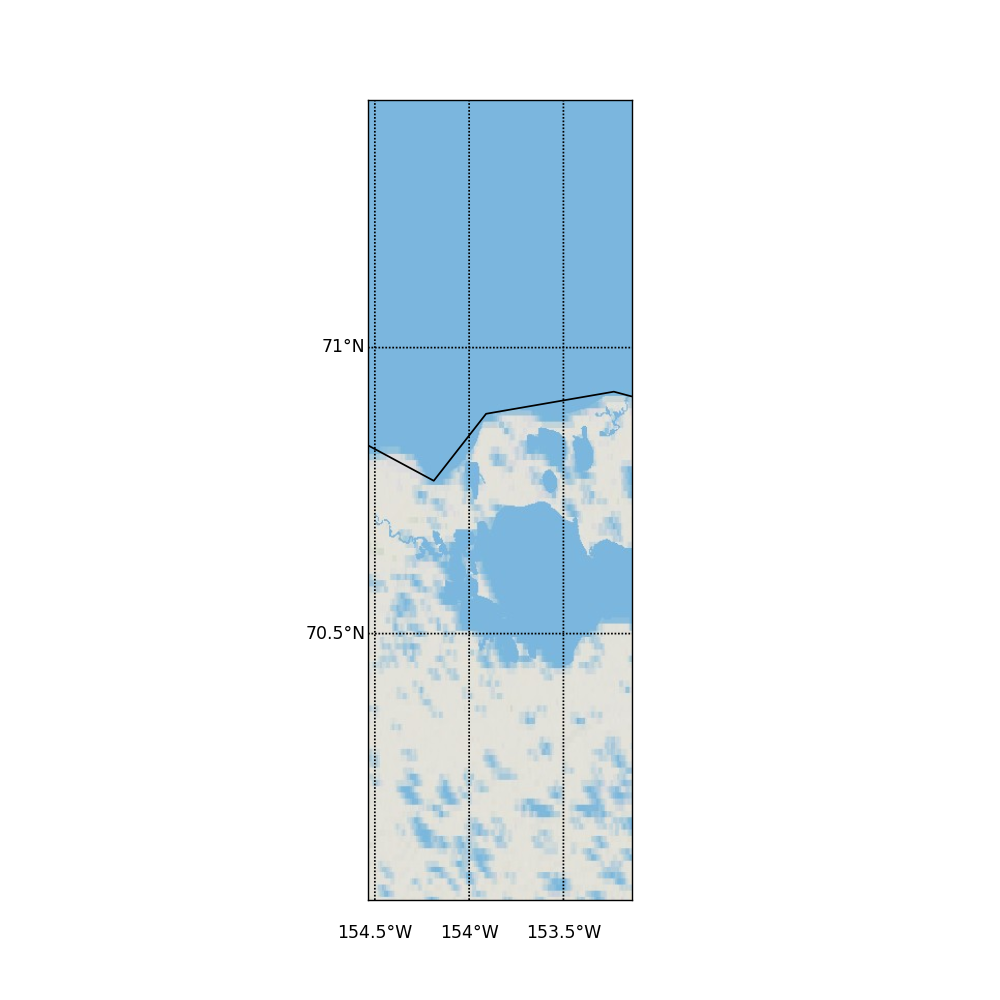

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=-17202905.453341793,11076173.816537216,-17047058.166231215,11548446.09584224&bboxSR=3857&imageSR=3857&size=1500,4545&dpi=96&format=png32&transparent=true&f=image


NameError: name 'Jan_Feb_DAV_avg' is not defined

In [51]:
# PLOT WINTER DAV MAP
# if getting errors, likely because there are 0 or only 1 early melt event for the subset
fig = plt.figure(figsize=(8,8))
# create figure and axes instances
#fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#ax = fig.add_subplot(121)
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=lon_start,lat_0=lat_start,lat_ts=90.,\
            llcrnrlat=(lat_start-.7),urcrnrlat=(lat_start+.7),\
            llcrnrlon=(lon_start-.7),urcrnrlon=(lon_start+.7),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

x,y=m(pixel_lons, pixel_lats)
#m.plot(x,y, 'bs', markersize=11, markeredgewidth=1, alpha=0.2)
m.scatter(x,y,c=Jan_Feb_DAV_avg, s=100, marker='s',lw=0,cmap='Blues', alpha=.8)
#x,y=m(ISAlons,ISAlats)
#m.plot(x,y,'ro',markersize=2,markeredgewidth=0.0)
plt.title(sensor_SIR+'-'+Site+' - DAV - (Avg '+str(Years[0])+'-'+str(Years[-1])+')')

# plot a red line on colorbar for the GRD mean - all years
cbar=plt.colorbar()
cbar.ax.hlines(cbar.norm(Jan_Feb_DAV_GRD_all), 0, 1, color='green') 

plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=lon_start,lat_0=lat_start,lat_ts=90.,\
            llcrnrlat=(lat_start-.7),urcrnrlat=(lat_start+.7),\
            llcrnrlon=(lon_start-.7),urcrnrlon=(lon_start+.7),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

#x,y=m(pixel_lons, pixel_lats)
#m.plot(x,y, 'bs', markersize=11, markeredgewidth=1, alpha=0.2)
#m.scatter(x,y,c=MOD_DOY_array, s=150, marker='s',lw=0,cmap='Blues', alpha=.0)
#x,y=m(ISAlons,ISAlats)
#m.plot(x,y,'ro',markersize=2,markeredgewidth=0.0)
plt.title(sensor_SIR+'-'+Site+' - DAV - (Avg '+str(Years[0])+'-'+str(Years[-1])+')')
#plt.colorbar()
plt.show()



<IPython.core.display.Javascript object>


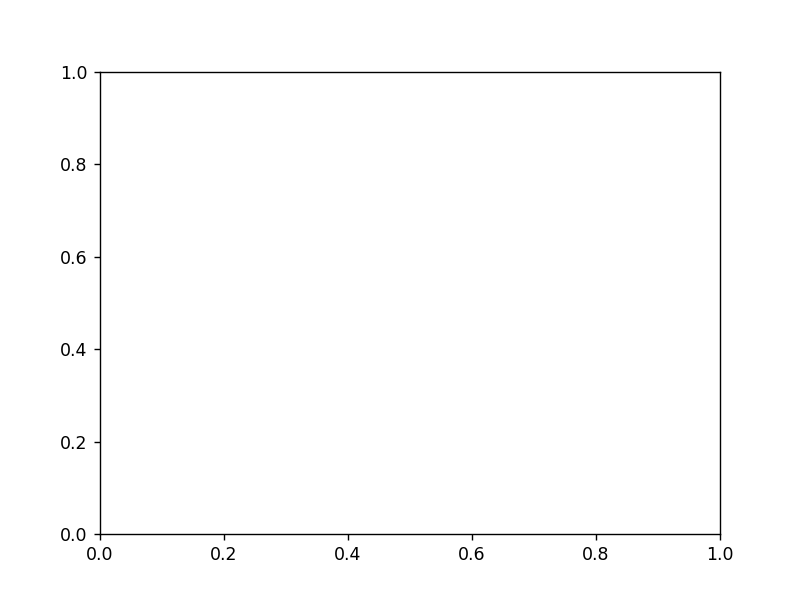

NameError: name 'Jan_Feb_DAV_avg' is not defined

In [52]:
# winter DAV histogram
plt.close()
fig,ax=plt.subplots()
ax.hist(Jan_Feb_DAV_avg)
avg=np.mean(Jan_Feb_DAV_avg)  # calculate average winter DAV all pixels
ax.axvline(x=avg, color='blue', linestyle='dashed')  # plot a line for the average winter DAV for all pixels
ax.axvline(x=Jan_Feb_DAV_GRD_all, color='red')  # plot a line for winter DAV for GRD pixel
ax.set_xlabel('DAV (K)')
ax.set_ylabel('Count')
ax.set_title('Winter (Jan-Feb) DAV')

In [53]:
#need to run this cell for the max DAV to work
y_dims_list=list(range(len(CETB_SIR[0,:,0])))  # creates a list of the y-dimension pixel indices, used for plotting
x_dims_list=list(range(len(CETB_SIR[0,0,:])))	# creates a list of the x-dimension pixel indices, for plotting
y_s=list(range(rows_cols_env[0],rows_cols_env[1]))  # makes a list of the y(row) numbers so the dataframe of early melt events can be indexed
x_s=list(range(rows_cols_env[2],rows_cols_env[3]))  # makes a list of the x(col) numbers so the dataframe of early melt events can be indexed

In [54]:
# create array of the max DAV for each pixel for all years
DAV_frame=pd.DataFrame()
for i in y_dims_list:
    for j in x_dims_list:
        column=pd.DataFrame(data=DAV_SIR[:,i,j], columns=[str(y_s[i])+','+str(x_s[j])])
        DAV_frame=pd.concat([DAV_frame,column],axis=1)
DAV_frame=DAV_frame.set_index(cal_date)
#DAV_frame=DAV_frame.groupby(pd.Grouper(freq='A')).max()
DAV_max_array=DAV_frame.max().values
DAV_max_array

KeyError: "None of [Timestamp('2019-01-01 06:00:00'), Timestamp('2019-01-01 18:00:00'), Timestamp('2019-01-02 06:00:00'), Timestamp('2019-01-02 18:00:00'), Timestamp('2019-01-03 06:00:00'), Timestamp('2019-01-03 18:00:00'), Timestamp('2019-01-04 06:00:00'), Timestamp('2019-01-04 18:00:00'), Timestamp('2019-01-05 06:00:00'), Timestamp('2019-01-05 18:00:00'), Timestamp('2019-01-06 06:00:00'), Timestamp('2019-01-06 18:00:00'), Timestamp('2019-01-07 06:00:00'), Timestamp('2019-01-07 18:00:00'), Timestamp('2019-01-08 06:00:00'), Timestamp('2019-01-08 18:00:00'), Timestamp('2019-01-09 06:00:00'), Timestamp('2019-01-09 18:00:00'), Timestamp('2019-01-10 06:00:00'), Timestamp('2019-01-10 18:00:00'), Timestamp('2019-01-11 06:00:00'), Timestamp('2019-01-11 18:00:00'), Timestamp('2019-01-12 06:00:00'), Timestamp('2019-01-12 18:00:00'), Timestamp('2019-01-13 06:00:00'), Timestamp('2019-01-13 18:00:00'), Timestamp('2019-01-14 06:00:00'), Timestamp('2019-01-14 18:00:00'), Timestamp('2019-01-15 06:00:00'), Timestamp('2019-01-15 18:00:00'), Timestamp('2019-01-16 06:00:00'), Timestamp('2019-01-16 18:00:00'), Timestamp('2019-01-17 06:00:00'), Timestamp('2019-01-17 18:00:00'), Timestamp('2019-01-18 06:00:00'), Timestamp('2019-01-18 18:00:00'), Timestamp('2019-01-19 06:00:00'), Timestamp('2019-01-19 18:00:00'), Timestamp('2019-01-20 06:00:00'), Timestamp('2019-01-20 18:00:00'), Timestamp('2019-01-21 06:00:00'), Timestamp('2019-01-21 18:00:00'), Timestamp('2019-01-22 06:00:00'), Timestamp('2019-01-22 18:00:00'), Timestamp('2019-01-23 06:00:00'), Timestamp('2019-01-23 18:00:00'), Timestamp('2019-01-24 06:00:00'), Timestamp('2019-01-24 18:00:00'), Timestamp('2019-01-25 06:00:00'), Timestamp('2019-01-25 18:00:00'), Timestamp('2019-01-26 06:00:00'), Timestamp('2019-01-26 18:00:00'), Timestamp('2019-01-27 06:00:00'), Timestamp('2019-01-27 18:00:00'), Timestamp('2019-01-28 06:00:00'), Timestamp('2019-01-28 18:00:00'), Timestamp('2019-01-29 06:00:00'), Timestamp('2019-01-29 18:00:00'), Timestamp('2019-01-30 06:00:00'), Timestamp('2019-01-30 18:00:00'), Timestamp('2019-01-31 06:00:00'), Timestamp('2019-01-31 18:00:00'), Timestamp('2019-02-01 06:00:00'), Timestamp('2019-02-01 18:00:00'), Timestamp('2019-02-02 06:00:00'), Timestamp('2019-02-02 18:00:00'), Timestamp('2019-02-03 06:00:00'), Timestamp('2019-02-03 18:00:00'), Timestamp('2019-02-04 06:00:00'), Timestamp('2019-02-04 18:00:00'), Timestamp('2019-02-05 06:00:00'), Timestamp('2019-02-05 18:00:00'), Timestamp('2019-02-06 06:00:00'), Timestamp('2019-02-06 18:00:00'), Timestamp('2019-02-07 06:00:00'), Timestamp('2019-02-07 18:00:00'), Timestamp('2019-02-08 06:00:00'), Timestamp('2019-02-08 18:00:00'), Timestamp('2019-02-09 06:00:00'), Timestamp('2019-02-09 18:00:00'), Timestamp('2019-02-10 06:00:00'), Timestamp('2019-02-10 18:00:00'), Timestamp('2019-02-11 06:00:00'), Timestamp('2019-02-11 18:00:00'), Timestamp('2019-02-12 06:00:00'), Timestamp('2019-02-12 18:00:00'), Timestamp('2019-02-13 06:00:00'), Timestamp('2019-02-13 18:00:00'), Timestamp('2019-02-14 06:00:00'), Timestamp('2019-02-14 18:00:00'), Timestamp('2019-02-15 06:00:00'), Timestamp('2019-02-15 18:00:00'), Timestamp('2019-02-16 06:00:00'), Timestamp('2019-02-16 18:00:00'), Timestamp('2019-02-17 06:00:00'), Timestamp('2019-02-17 18:00:00'), Timestamp('2019-02-18 06:00:00'), Timestamp('2019-02-18 18:00:00'), Timestamp('2019-02-19 06:00:00'), Timestamp('2019-02-19 18:00:00'), Timestamp('2019-02-20 06:00:00'), Timestamp('2019-02-20 18:00:00'), Timestamp('2019-02-21 06:00:00'), Timestamp('2019-02-21 18:00:00'), Timestamp('2019-02-22 06:00:00'), Timestamp('2019-02-22 18:00:00'), Timestamp('2019-02-23 06:00:00'), Timestamp('2019-02-23 18:00:00'), Timestamp('2019-02-24 06:00:00'), Timestamp('2019-02-24 18:00:00'), Timestamp('2019-02-25 06:00:00'), Timestamp('2019-02-25 18:00:00'), Timestamp('2019-02-26 06:00:00'), Timestamp('2019-02-26 18:00:00'), Timestamp('2019-02-27 06:00:00'), Timestamp('2019-02-27 18:00:00'), Timestamp('2019-02-28 06:00:00'), Timestamp('2019-02-28 18:00:00'), Timestamp('2019-03-01 06:00:00'), Timestamp('2019-03-01 18:00:00'), Timestamp('2019-03-02 06:00:00'), Timestamp('2019-03-02 18:00:00'), Timestamp('2019-03-03 06:00:00'), Timestamp('2019-03-03 18:00:00'), Timestamp('2019-03-04 06:00:00'), Timestamp('2019-03-04 18:00:00'), Timestamp('2019-03-05 06:00:00'), Timestamp('2019-03-05 18:00:00'), Timestamp('2019-03-06 06:00:00'), Timestamp('2019-03-06 18:00:00'), Timestamp('2019-03-07 06:00:00'), Timestamp('2019-03-07 18:00:00'), Timestamp('2019-03-08 06:00:00'), Timestamp('2019-03-08 18:00:00'), Timestamp('2019-03-09 06:00:00'), Timestamp('2019-03-09 18:00:00'), Timestamp('2019-03-10 06:00:00'), Timestamp('2019-03-10 18:00:00'), Timestamp('2019-03-11 06:00:00'), Timestamp('2019-03-11 18:00:00'), Timestamp('2019-03-12 06:00:00'), Timestamp('2019-03-12 18:00:00'), Timestamp('2019-03-13 06:00:00'), Timestamp('2019-03-13 18:00:00'), Timestamp('2019-03-14 06:00:00'), Timestamp('2019-03-14 18:00:00'), Timestamp('2019-03-15 06:00:00'), Timestamp('2019-03-15 18:00:00'), Timestamp('2019-03-16 06:00:00'), Timestamp('2019-03-16 18:00:00'), Timestamp('2019-03-17 06:00:00'), Timestamp('2019-03-17 18:00:00'), Timestamp('2019-03-18 06:00:00'), Timestamp('2019-03-18 18:00:00'), Timestamp('2019-03-19 06:00:00'), Timestamp('2019-03-19 18:00:00'), Timestamp('2019-03-20 06:00:00'), Timestamp('2019-03-20 18:00:00'), Timestamp('2019-03-21 06:00:00'), Timestamp('2019-03-21 18:00:00'), Timestamp('2019-03-22 06:00:00'), Timestamp('2019-03-22 18:00:00'), Timestamp('2019-03-23 06:00:00'), Timestamp('2019-03-23 18:00:00'), Timestamp('2019-03-24 06:00:00'), Timestamp('2019-03-24 18:00:00'), Timestamp('2019-03-25 06:00:00'), Timestamp('2019-03-25 18:00:00'), Timestamp('2019-03-26 06:00:00'), Timestamp('2019-03-26 18:00:00'), Timestamp('2019-03-27 06:00:00'), Timestamp('2019-03-27 18:00:00'), Timestamp('2019-03-28 06:00:00'), Timestamp('2019-03-28 18:00:00'), Timestamp('2019-03-29 06:00:00'), Timestamp('2019-03-29 18:00:00'), Timestamp('2019-03-30 06:00:00'), Timestamp('2019-03-30 18:00:00'), Timestamp('2019-03-31 06:00:00'), Timestamp('2019-03-31 18:00:00'), Timestamp('2019-04-01 06:00:00'), Timestamp('2019-04-01 18:00:00'), Timestamp('2019-04-02 06:00:00'), Timestamp('2019-04-02 18:00:00'), Timestamp('2019-04-03 06:00:00'), Timestamp('2019-04-03 18:00:00'), Timestamp('2019-04-04 06:00:00'), Timestamp('2019-04-04 18:00:00'), Timestamp('2019-04-05 06:00:00'), Timestamp('2019-04-05 18:00:00'), Timestamp('2019-04-06 06:00:00'), Timestamp('2019-04-06 18:00:00'), Timestamp('2019-04-07 06:00:00'), Timestamp('2019-04-07 18:00:00'), Timestamp('2019-04-08 06:00:00'), Timestamp('2019-04-08 18:00:00'), Timestamp('2019-04-09 06:00:00'), Timestamp('2019-04-09 18:00:00'), Timestamp('2019-04-10 06:00:00'), Timestamp('2019-04-10 18:00:00'), Timestamp('2019-04-11 06:00:00'), Timestamp('2019-04-11 18:00:00'), Timestamp('2019-04-12 06:00:00'), Timestamp('2019-04-12 18:00:00'), Timestamp('2019-04-13 06:00:00'), Timestamp('2019-04-13 18:00:00'), Timestamp('2019-04-14 06:00:00'), Timestamp('2019-04-14 18:00:00'), Timestamp('2019-04-15 06:00:00'), Timestamp('2019-04-15 18:00:00'), Timestamp('2019-04-16 06:00:00'), Timestamp('2019-04-16 18:00:00'), Timestamp('2019-04-17 06:00:00'), Timestamp('2019-04-17 18:00:00'), Timestamp('2019-04-18 06:00:00'), Timestamp('2019-04-18 18:00:00'), Timestamp('2019-04-19 06:00:00'), Timestamp('2019-04-19 18:00:00'), Timestamp('2019-04-20 06:00:00'), Timestamp('2019-04-20 18:00:00'), Timestamp('2019-04-21 06:00:00'), Timestamp('2019-04-21 18:00:00'), Timestamp('2019-04-22 06:00:00'), Timestamp('2019-04-22 18:00:00'), Timestamp('2019-04-23 06:00:00'), Timestamp('2019-04-23 18:00:00'), Timestamp('2019-04-24 06:00:00'), Timestamp('2019-04-24 18:00:00'), Timestamp('2019-04-25 06:00:00'), Timestamp('2019-04-25 18:00:00'), Timestamp('2019-04-26 06:00:00'), Timestamp('2019-04-26 18:00:00'), Timestamp('2019-04-27 06:00:00'), Timestamp('2019-04-27 18:00:00'), Timestamp('2019-04-28 06:00:00'), Timestamp('2019-04-28 18:00:00'), Timestamp('2019-04-29 06:00:00'), Timestamp('2019-04-29 18:00:00'), Timestamp('2019-04-30 06:00:00'), Timestamp('2019-04-30 18:00:00'), Timestamp('2019-05-01 06:00:00'), Timestamp('2019-05-01 18:00:00'), Timestamp('2019-05-02 06:00:00'), Timestamp('2019-05-02 18:00:00'), Timestamp('2019-05-03 06:00:00'), Timestamp('2019-05-03 18:00:00'), Timestamp('2019-05-04 06:00:00'), Timestamp('2019-05-04 18:00:00'), Timestamp('2019-05-05 06:00:00'), Timestamp('2019-05-05 18:00:00'), Timestamp('2019-05-06 06:00:00'), Timestamp('2019-05-06 18:00:00'), Timestamp('2019-05-07 06:00:00'), Timestamp('2019-05-07 18:00:00'), Timestamp('2019-05-08 06:00:00'), Timestamp('2019-05-08 18:00:00'), Timestamp('2019-05-09 06:00:00'), Timestamp('2019-05-09 18:00:00'), Timestamp('2019-05-10 06:00:00'), Timestamp('2019-05-10 18:00:00'), Timestamp('2019-05-11 06:00:00'), Timestamp('2019-05-11 18:00:00'), Timestamp('2019-05-12 06:00:00'), Timestamp('2019-05-12 18:00:00'), Timestamp('2019-05-13 06:00:00'), Timestamp('2019-05-13 18:00:00'), Timestamp('2019-05-14 06:00:00'), Timestamp('2019-05-14 18:00:00'), Timestamp('2019-05-15 06:00:00'), Timestamp('2019-05-15 18:00:00'), Timestamp('2019-05-16 06:00:00'), Timestamp('2019-05-16 18:00:00'), Timestamp('2019-05-17 06:00:00'), Timestamp('2019-05-17 18:00:00'), Timestamp('2019-05-18 06:00:00'), Timestamp('2019-05-18 18:00:00'), Timestamp('2019-05-19 06:00:00'), Timestamp('2019-05-19 18:00:00'), Timestamp('2019-05-20 06:00:00'), Timestamp('2019-05-20 18:00:00'), Timestamp('2019-05-21 06:00:00'), Timestamp('2019-05-21 18:00:00'), Timestamp('2019-05-22 06:00:00'), Timestamp('2019-05-22 18:00:00'), Timestamp('2019-05-23 06:00:00'), Timestamp('2019-05-23 18:00:00'), Timestamp('2019-05-24 06:00:00'), Timestamp('2019-05-24 18:00:00'), Timestamp('2019-05-25 06:00:00'), Timestamp('2019-05-25 18:00:00'), Timestamp('2019-05-26 06:00:00'), Timestamp('2019-05-26 18:00:00'), Timestamp('2019-05-27 06:00:00'), Timestamp('2019-05-27 18:00:00'), Timestamp('2019-05-28 06:00:00'), Timestamp('2019-05-28 18:00:00'), Timestamp('2019-05-29 06:00:00'), Timestamp('2019-05-29 18:00:00'), Timestamp('2019-05-30 06:00:00'), Timestamp('2019-05-30 18:00:00'), Timestamp('2019-05-31 06:00:00'), Timestamp('2019-05-31 18:00:00'), Timestamp('2019-06-01 06:00:00'), Timestamp('2019-06-01 18:00:00'), Timestamp('2019-06-02 06:00:00'), Timestamp('2019-06-02 18:00:00'), Timestamp('2019-06-03 06:00:00'), Timestamp('2019-06-03 18:00:00'), Timestamp('2019-06-04 06:00:00'), Timestamp('2019-06-04 18:00:00'), Timestamp('2019-06-05 06:00:00'), Timestamp('2019-06-05 18:00:00'), Timestamp('2019-06-06 06:00:00'), Timestamp('2019-06-06 18:00:00'), Timestamp('2019-06-07 06:00:00'), Timestamp('2019-06-07 18:00:00'), Timestamp('2019-06-08 06:00:00'), Timestamp('2019-06-08 18:00:00'), Timestamp('2019-06-09 06:00:00'), Timestamp('2019-06-09 18:00:00'), Timestamp('2019-06-10 06:00:00'), Timestamp('2019-06-10 18:00:00'), Timestamp('2019-06-11 06:00:00'), Timestamp('2019-06-11 18:00:00'), Timestamp('2019-06-12 06:00:00'), Timestamp('2019-06-12 18:00:00'), Timestamp('2019-06-13 06:00:00'), Timestamp('2019-06-13 18:00:00'), Timestamp('2019-06-14 06:00:00'), Timestamp('2019-06-14 18:00:00'), Timestamp('2019-06-15 06:00:00'), Timestamp('2019-06-15 18:00:00'), Timestamp('2019-06-16 06:00:00'), Timestamp('2019-06-16 18:00:00'), Timestamp('2019-06-17 06:00:00'), Timestamp('2019-06-17 18:00:00'), Timestamp('2019-06-18 06:00:00'), Timestamp('2019-06-18 18:00:00'), Timestamp('2019-06-19 06:00:00'), Timestamp('2019-06-19 18:00:00'), Timestamp('2019-06-20 06:00:00'), Timestamp('2019-06-20 18:00:00'), Timestamp('2019-06-21 06:00:00'), Timestamp('2019-06-21 18:00:00'), Timestamp('2019-06-22 06:00:00'), Timestamp('2019-06-22 18:00:00'), Timestamp('2019-06-23 06:00:00'), Timestamp('2019-06-23 18:00:00'), Timestamp('2019-06-24 06:00:00'), Timestamp('2019-06-24 18:00:00'), Timestamp('2019-06-25 06:00:00'), Timestamp('2019-06-25 18:00:00'), Timestamp('2019-06-26 06:00:00'), Timestamp('2019-06-26 18:00:00'), Timestamp('2019-06-27 06:00:00'), Timestamp('2019-06-27 18:00:00'), Timestamp('2019-06-28 06:00:00'), Timestamp('2019-06-28 18:00:00'), Timestamp('2019-06-29 06:00:00'), Timestamp('2019-06-29 18:00:00'), Timestamp('2019-06-30 06:00:00'), Timestamp('2019-06-30 18:00:00'), Timestamp('2019-07-01 06:00:00'), Timestamp('2019-07-01 18:00:00'), Timestamp('2019-07-02 06:00:00'), Timestamp('2019-07-02 18:00:00'), Timestamp('2019-07-03 06:00:00'), Timestamp('2019-07-03 18:00:00'), Timestamp('2019-07-04 06:00:00'), Timestamp('2019-07-04 18:00:00'), Timestamp('2019-07-05 06:00:00'), Timestamp('2019-07-05 18:00:00'), Timestamp('2019-07-06 06:00:00'), Timestamp('2019-07-06 18:00:00'), Timestamp('2019-07-07 06:00:00'), Timestamp('2019-07-07 18:00:00'), Timestamp('2019-07-08 06:00:00'), Timestamp('2019-07-08 18:00:00'), Timestamp('2019-07-09 06:00:00'), Timestamp('2019-07-09 18:00:00'), Timestamp('2019-07-10 06:00:00'), Timestamp('2019-07-10 18:00:00'), Timestamp('2019-07-11 06:00:00'), Timestamp('2019-07-11 18:00:00'), Timestamp('2019-07-12 06:00:00'), Timestamp('2019-07-12 18:00:00'), Timestamp('2019-07-13 06:00:00'), Timestamp('2019-07-13 18:00:00'), Timestamp('2019-07-14 06:00:00'), Timestamp('2019-07-14 18:00:00'), Timestamp('2019-07-15 06:00:00'), Timestamp('2019-07-15 18:00:00'), Timestamp('2019-07-16 06:00:00'), Timestamp('2019-07-16 18:00:00'), Timestamp('2019-07-17 06:00:00'), Timestamp('2019-07-17 18:00:00'), Timestamp('2019-07-18 06:00:00'), Timestamp('2019-07-18 18:00:00'), Timestamp('2019-07-19 06:00:00'), Timestamp('2019-07-19 18:00:00'), Timestamp('2019-07-20 06:00:00'), Timestamp('2019-07-20 18:00:00'), Timestamp('2019-07-21 06:00:00'), Timestamp('2019-07-21 18:00:00'), Timestamp('2019-07-22 06:00:00'), Timestamp('2019-07-22 18:00:00'), Timestamp('2019-07-23 06:00:00'), Timestamp('2019-07-23 18:00:00'), Timestamp('2019-07-24 06:00:00'), Timestamp('2019-07-24 18:00:00'), Timestamp('2019-07-25 06:00:00'), Timestamp('2019-07-25 18:00:00'), Timestamp('2019-07-26 06:00:00'), Timestamp('2019-07-26 18:00:00'), Timestamp('2019-07-27 06:00:00'), Timestamp('2019-07-27 18:00:00'), Timestamp('2019-07-28 06:00:00'), Timestamp('2019-07-28 18:00:00'), Timestamp('2019-07-29 06:00:00'), Timestamp('2019-07-29 18:00:00'), Timestamp('2019-07-30 06:00:00'), Timestamp('2019-07-30 18:00:00'), Timestamp('2019-07-31 06:00:00'), Timestamp('2019-07-31 18:00:00'), Timestamp('2019-08-01 06:00:00'), Timestamp('2019-08-01 18:00:00'), Timestamp('2019-08-02 06:00:00'), Timestamp('2019-08-02 18:00:00'), Timestamp('2019-08-03 06:00:00'), Timestamp('2019-08-03 18:00:00'), Timestamp('2019-08-04 06:00:00'), Timestamp('2019-08-04 18:00:00'), Timestamp('2019-08-05 06:00:00'), Timestamp('2019-08-05 18:00:00'), Timestamp('2019-08-06 06:00:00'), Timestamp('2019-08-06 18:00:00'), Timestamp('2019-08-07 06:00:00'), Timestamp('2019-08-07 18:00:00'), Timestamp('2019-08-08 06:00:00'), Timestamp('2019-08-08 18:00:00'), Timestamp('2019-08-09 06:00:00'), Timestamp('2019-08-09 18:00:00'), Timestamp('2019-08-10 06:00:00'), Timestamp('2019-08-10 18:00:00'), Timestamp('2019-08-11 06:00:00'), Timestamp('2019-08-11 18:00:00'), Timestamp('2019-08-12 06:00:00'), Timestamp('2019-08-12 18:00:00'), Timestamp('2019-08-13 06:00:00'), Timestamp('2019-08-13 18:00:00'), Timestamp('2019-08-14 06:00:00'), Timestamp('2019-08-14 18:00:00'), Timestamp('2019-08-15 06:00:00'), Timestamp('2019-08-15 18:00:00'), Timestamp('2019-08-16 06:00:00'), Timestamp('2019-08-16 18:00:00'), Timestamp('2019-08-17 06:00:00'), Timestamp('2019-08-17 18:00:00'), Timestamp('2019-08-18 06:00:00'), Timestamp('2019-08-18 18:00:00'), Timestamp('2019-08-19 06:00:00'), Timestamp('2019-08-19 18:00:00'), Timestamp('2019-08-20 06:00:00'), Timestamp('2019-08-20 18:00:00'), Timestamp('2019-08-21 06:00:00'), Timestamp('2019-08-21 18:00:00'), Timestamp('2019-08-22 06:00:00'), Timestamp('2019-08-22 18:00:00'), Timestamp('2019-08-23 06:00:00'), Timestamp('2019-08-23 18:00:00'), Timestamp('2019-08-24 06:00:00'), Timestamp('2019-08-24 18:00:00'), Timestamp('2019-08-25 06:00:00'), Timestamp('2019-08-25 18:00:00'), Timestamp('2019-08-26 06:00:00'), Timestamp('2019-08-26 18:00:00'), Timestamp('2019-08-27 06:00:00'), Timestamp('2019-08-27 18:00:00'), Timestamp('2019-08-28 06:00:00'), Timestamp('2019-08-28 18:00:00'), Timestamp('2019-08-29 06:00:00'), Timestamp('2019-08-29 18:00:00'), Timestamp('2019-08-30 06:00:00'), Timestamp('2019-08-30 18:00:00'), Timestamp('2019-08-31 06:00:00'), Timestamp('2019-08-31 18:00:00'), Timestamp('2019-09-01 06:00:00'), Timestamp('2019-09-01 18:00:00'), Timestamp('2019-09-02 06:00:00'), Timestamp('2019-09-02 18:00:00'), Timestamp('2019-09-03 06:00:00'), Timestamp('2019-09-03 18:00:00'), Timestamp('2019-09-04 06:00:00'), Timestamp('2019-09-04 18:00:00'), Timestamp('2019-09-05 06:00:00'), Timestamp('2019-09-05 18:00:00'), Timestamp('2019-09-06 06:00:00'), Timestamp('2019-09-06 18:00:00'), Timestamp('2019-09-07 06:00:00'), Timestamp('2019-09-07 18:00:00'), Timestamp('2019-09-08 06:00:00'), Timestamp('2019-09-08 18:00:00'), Timestamp('2019-09-09 06:00:00'), Timestamp('2019-09-09 18:00:00'), Timestamp('2019-09-10 06:00:00'), Timestamp('2019-09-10 18:00:00'), Timestamp('2019-09-11 06:00:00'), Timestamp('2019-09-11 18:00:00'), Timestamp('2019-09-12 06:00:00'), Timestamp('2019-09-12 18:00:00'), Timestamp('2019-09-13 06:00:00'), Timestamp('2019-09-13 18:00:00'), Timestamp('2019-09-14 06:00:00'), Timestamp('2019-09-14 18:00:00'), Timestamp('2019-09-15 06:00:00'), Timestamp('2019-09-15 18:00:00'), Timestamp('2019-09-16 06:00:00'), Timestamp('2019-09-16 18:00:00'), Timestamp('2019-09-17 06:00:00'), Timestamp('2019-09-17 18:00:00'), Timestamp('2019-09-18 06:00:00'), Timestamp('2019-09-18 18:00:00'), Timestamp('2019-09-19 06:00:00'), Timestamp('2019-09-19 18:00:00'), Timestamp('2019-09-20 06:00:00'), Timestamp('2019-09-20 18:00:00'), Timestamp('2019-09-21 06:00:00'), Timestamp('2019-09-21 18:00:00'), Timestamp('2019-09-22 06:00:00'), Timestamp('2019-09-22 18:00:00'), Timestamp('2019-09-23 06:00:00'), Timestamp('2019-09-23 18:00:00'), Timestamp('2019-09-24 06:00:00'), Timestamp('2019-09-24 18:00:00'), Timestamp('2019-09-25 06:00:00'), Timestamp('2019-09-25 18:00:00'), Timestamp('2019-09-26 06:00:00'), Timestamp('2019-09-26 18:00:00'), Timestamp('2019-09-27 06:00:00'), Timestamp('2019-09-27 18:00:00'), Timestamp('2019-09-28 06:00:00'), Timestamp('2019-09-28 18:00:00'), Timestamp('2019-09-29 06:00:00'), Timestamp('2019-09-29 18:00:00'), Timestamp('2019-09-30 06:00:00'), Timestamp('2019-09-30 18:00:00'), Timestamp('2019-10-01 06:00:00'), Timestamp('2019-10-01 18:00:00'), Timestamp('2019-10-02 06:00:00'), Timestamp('2019-10-02 18:00:00'), Timestamp('2019-10-03 06:00:00'), Timestamp('2019-10-03 18:00:00'), Timestamp('2019-10-04 06:00:00'), Timestamp('2019-10-04 18:00:00'), Timestamp('2019-10-05 06:00:00'), Timestamp('2019-10-05 18:00:00'), Timestamp('2019-10-06 06:00:00'), Timestamp('2019-10-06 18:00:00'), Timestamp('2019-10-07 06:00:00'), Timestamp('2019-10-07 18:00:00'), Timestamp('2019-10-08 06:00:00'), Timestamp('2019-10-08 18:00:00'), Timestamp('2019-10-09 06:00:00'), Timestamp('2019-10-09 18:00:00'), Timestamp('2019-10-10 06:00:00'), Timestamp('2019-10-10 18:00:00'), Timestamp('2019-10-11 06:00:00'), Timestamp('2019-10-11 18:00:00'), Timestamp('2019-10-12 06:00:00'), Timestamp('2019-10-12 18:00:00'), Timestamp('2019-10-13 06:00:00'), Timestamp('2019-10-13 18:00:00'), Timestamp('2019-10-14 06:00:00'), Timestamp('2019-10-14 18:00:00'), Timestamp('2019-10-15 06:00:00'), Timestamp('2019-10-15 18:00:00'), Timestamp('2019-10-16 06:00:00'), Timestamp('2019-10-16 18:00:00'), Timestamp('2019-10-17 06:00:00'), Timestamp('2019-10-17 18:00:00'), Timestamp('2019-10-18 06:00:00'), Timestamp('2019-10-18 18:00:00'), Timestamp('2019-10-19 06:00:00'), Timestamp('2019-10-19 18:00:00'), Timestamp('2019-10-20 06:00:00'), Timestamp('2019-10-20 18:00:00'), Timestamp('2019-10-21 06:00:00'), Timestamp('2019-10-21 18:00:00'), Timestamp('2019-10-22 06:00:00'), Timestamp('2019-10-22 18:00:00'), Timestamp('2019-10-23 06:00:00'), Timestamp('2019-10-23 18:00:00'), Timestamp('2019-10-24 06:00:00'), Timestamp('2019-10-24 18:00:00'), Timestamp('2019-10-25 06:00:00'), Timestamp('2019-10-25 18:00:00'), Timestamp('2019-10-26 06:00:00'), Timestamp('2019-10-26 18:00:00'), Timestamp('2019-10-27 06:00:00'), Timestamp('2019-10-27 18:00:00'), Timestamp('2019-10-28 06:00:00'), Timestamp('2019-10-28 18:00:00'), Timestamp('2019-10-29 06:00:00'), Timestamp('2019-10-29 18:00:00'), Timestamp('2019-10-30 06:00:00'), Timestamp('2019-10-30 18:00:00'), Timestamp('2019-10-31 06:00:00'), Timestamp('2019-10-31 18:00:00'), Timestamp('2019-11-01 06:00:00'), Timestamp('2019-11-01 18:00:00'), Timestamp('2019-11-02 06:00:00'), Timestamp('2019-11-02 18:00:00'), Timestamp('2019-11-03 06:00:00'), Timestamp('2019-11-03 18:00:00'), Timestamp('2019-11-04 06:00:00'), Timestamp('2019-11-04 18:00:00'), Timestamp('2019-11-05 06:00:00'), Timestamp('2019-11-05 18:00:00'), Timestamp('2019-11-06 06:00:00'), Timestamp('2019-11-06 18:00:00'), Timestamp('2019-11-07 06:00:00'), Timestamp('2019-11-07 18:00:00'), Timestamp('2019-11-08 06:00:00'), Timestamp('2019-11-08 18:00:00'), Timestamp('2019-11-09 06:00:00'), Timestamp('2019-11-09 18:00:00'), Timestamp('2019-11-10 06:00:00'), Timestamp('2019-11-10 18:00:00'), Timestamp('2019-11-11 06:00:00'), Timestamp('2019-11-11 18:00:00'), Timestamp('2019-11-12 06:00:00'), Timestamp('2019-11-12 18:00:00'), Timestamp('2019-11-13 06:00:00'), Timestamp('2019-11-13 18:00:00'), Timestamp('2019-11-14 06:00:00'), Timestamp('2019-11-14 18:00:00'), Timestamp('2019-11-15 06:00:00'), Timestamp('2019-11-15 18:00:00'), Timestamp('2019-11-16 06:00:00'), Timestamp('2019-11-16 18:00:00'), Timestamp('2019-11-17 06:00:00'), Timestamp('2019-11-17 18:00:00'), Timestamp('2019-11-18 06:00:00'), Timestamp('2019-11-18 18:00:00'), Timestamp('2019-11-19 06:00:00'), Timestamp('2019-11-19 18:00:00'), Timestamp('2019-11-20 06:00:00'), Timestamp('2019-11-20 18:00:00'), Timestamp('2019-11-21 06:00:00'), Timestamp('2019-11-21 18:00:00'), Timestamp('2019-11-22 06:00:00'), Timestamp('2019-11-22 18:00:00'), Timestamp('2019-11-23 06:00:00'), Timestamp('2019-11-23 18:00:00'), Timestamp('2019-11-24 06:00:00'), Timestamp('2019-11-24 18:00:00'), Timestamp('2019-11-25 06:00:00'), Timestamp('2019-11-25 18:00:00'), Timestamp('2019-11-26 06:00:00'), Timestamp('2019-11-26 18:00:00'), Timestamp('2019-11-27 06:00:00'), Timestamp('2019-11-27 18:00:00'), Timestamp('2019-11-28 06:00:00'), Timestamp('2019-11-28 18:00:00'), Timestamp('2019-11-29 06:00:00'), Timestamp('2019-11-29 18:00:00'), Timestamp('2019-11-30 06:00:00'), Timestamp('2019-11-30 18:00:00'), Timestamp('2019-12-01 06:00:00'), Timestamp('2019-12-01 18:00:00'), Timestamp('2019-12-02 06:00:00'), Timestamp('2019-12-02 18:00:00'), Timestamp('2019-12-03 06:00:00'), Timestamp('2019-12-03 18:00:00'), Timestamp('2019-12-04 06:00:00'), Timestamp('2019-12-04 18:00:00'), Timestamp('2019-12-05 06:00:00'), Timestamp('2019-12-05 18:00:00'), Timestamp('2019-12-06 06:00:00'), Timestamp('2019-12-06 18:00:00'), Timestamp('2019-12-07 06:00:00'), Timestamp('2019-12-07 18:00:00'), Timestamp('2019-12-08 06:00:00'), Timestamp('2019-12-08 18:00:00'), Timestamp('2019-12-09 06:00:00'), Timestamp('2019-12-09 18:00:00'), Timestamp('2019-12-10 06:00:00'), Timestamp('2019-12-10 18:00:00'), Timestamp('2019-12-11 06:00:00'), Timestamp('2019-12-11 18:00:00'), Timestamp('2019-12-12 06:00:00'), Timestamp('2019-12-12 18:00:00'), Timestamp('2019-12-13 06:00:00'), Timestamp('2019-12-13 18:00:00'), Timestamp('2019-12-14 06:00:00'), Timestamp('2019-12-14 18:00:00'), Timestamp('2019-12-15 06:00:00'), Timestamp('2019-12-15 18:00:00'), Timestamp('2019-12-16 06:00:00'), Timestamp('2019-12-16 18:00:00'), Timestamp('2019-12-17 06:00:00'), Timestamp('2019-12-17 18:00:00'), Timestamp('2019-12-18 06:00:00'), Timestamp('2019-12-18 18:00:00'), Timestamp('2019-12-19 06:00:00'), Timestamp('2019-12-19 18:00:00'), Timestamp('2019-12-20 06:00:00'), Timestamp('2019-12-20 18:00:00'), Timestamp('2019-12-21 06:00:00'), Timestamp('2019-12-21 18:00:00'), Timestamp('2019-12-22 06:00:00'), Timestamp('2019-12-22 18:00:00'), Timestamp('2019-12-23 06:00:00'), Timestamp('2019-12-23 18:00:00'), Timestamp('2019-12-24 06:00:00'), Timestamp('2019-12-24 18:00:00'), Timestamp('2019-12-25 06:00:00'), Timestamp('2019-12-25 18:00:00'), Timestamp('2019-12-26 06:00:00'), Timestamp('2019-12-26 18:00:00'), Timestamp('2019-12-27 06:00:00'), Timestamp('2019-12-27 18:00:00'), Timestamp('2019-12-28 06:00:00'), Timestamp('2019-12-28 18:00:00'), Timestamp('2019-12-29 06:00:00'), Timestamp('2019-12-29 18:00:00'), Timestamp('2019-12-30 06:00:00'), Timestamp('2019-12-30 18:00:00'), Timestamp('2019-12-31 06:00:00'), Timestamp('2019-12-31 18:00:00')] are in the columns"

In [ ]:
# create array of the max DAV for each pixel for year of interest
year=2019  #specify year
DAV_max_array_year=DAV_frame[str(year)].max().values
DAV_max_array_year

In [ ]:
DAV_max_GRD=np.nanmax(DAV_GRD)
DAV_max_GRD

In [ ]:
#Note this year needs to be the same as the max dav plot below
#year=2005
DAV_max_GRD_year=np.nanmax(DAV_GRD[cal_year==year])
DAV_max_GRD_year

In [ ]:
# PLOT MAX DAV MAP
#plot_type='all'
year = 2019
plot_type=year
#NOTE YEAR SPECIFIED UP A FEW LEVELS (~3)
#year=2005

if plot_type=='all':
    array=DAV_max_array
    title=sensor_SIR+'-'+Site+' - Max DAV (K) - (Avg of '+str(Years[0])+'-'+str(Years[-1])+')'
    GRD=DAV_max_GRD
elif plot_type==year:

    array=DAV_max_array_year
    GRD=DAV_max_GRD_year
    title=sensor_SIR+'-'+Site+' - Max DAV (K) - ('+str(year)+')'

fig = plt.figure(figsize=(8,8))
# create figure and axes instances
#fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#ax = fig.add_subplot(121)
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=lon_start,lat_0=lat_start,lat_ts=90.,\
            llcrnrlat=(lat_start-.7),urcrnrlat=(lat_start+.7),\
            llcrnrlon=(lon_start-.7),urcrnrlon=(lon_start+.7),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

x,y=m(pixel_lons, pixel_lats)
#m.plot(x,y, 'bs', markersize=11, markeredgewidth=1, alpha=0.2)
m.scatter(x,y,c=array, s=100, marker='s',lw=0,cmap='Blues', alpha=.8)
#x,y=m(ISAlons,ISAlats)
#m.plot(x,y,'ro',markersize=2,markeredgewidth=0.0)
plt.title(title)

# plot a red line on colorbar for the GRD max
cbar=plt.colorbar()
#cbar.ax.hlines(cbar.norm(DAV_max_GRD), 0, 1, color='red') 
cbar.ax.hlines(cbar.norm(DAV_max_GRD_year), 0, 1, color='red')
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=lon_start,lat_0=lat_start,lat_ts=90.,\
            llcrnrlat=(lat_start-.7),urcrnrlat=(lat_start+.7),\
            llcrnrlon=(lon_start-.7),urcrnrlon=(lon_start+.7),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

#x,y=m(pixel_lons, pixel_lats)
#m.plot(x,y, 'bs', markersize=11, markeredgewidth=1, alpha=0.2)
#m.scatter(x,y,c=MOD_DOY_array, s=150, marker='s',lw=0,cmap='Blues', alpha=.0)
#x,y=m(ISAlons,ISAlats)
#m.plot(x,y,'ro',markersize=2,markeredgewidth=0.0)
plt.title(title)
#plt.colorbar()
plt.show()

## Histograms

<IPython.core.display.Javascript object>


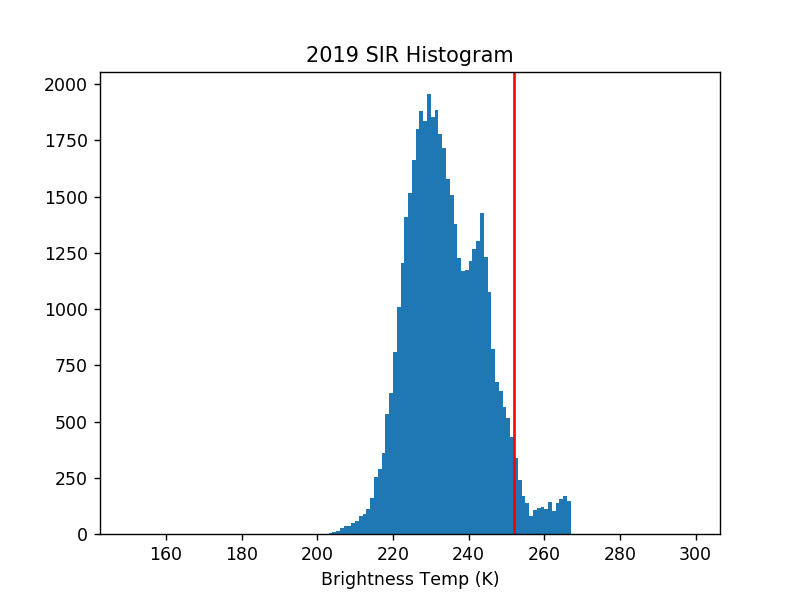

In [56]:
# generate histogram - SIR - pick year 
year=2019  # specify year here
Tb_threshold=252  #specify threshold
data = CETB_SIR[cal_year==year] # CETB_data for all pixels in subset
data = data[data>=0]
bins = range(150,300)  # bins for histogram
fig,ax=plt.subplots()
ax.axvline(x=Tb_threshold, color='red')
ax.hist(data, bins)
ax.set_title(str(year)+' SIR Histogram')
#ax.set_title(prefix+'row'+str(x)+'col'+str(y))
ax.set_xlabel('Brightness Temp (K)')
#fig.savefig('/home/mij216/Documents/GLaIL/'+prefix+'row'+str(x)+'col'+str(y)+'.png')
plt.savefig('../../jmr_plots/testIceland_Katla_F18_histsir2019.png')

<IPython.core.display.Javascript object>


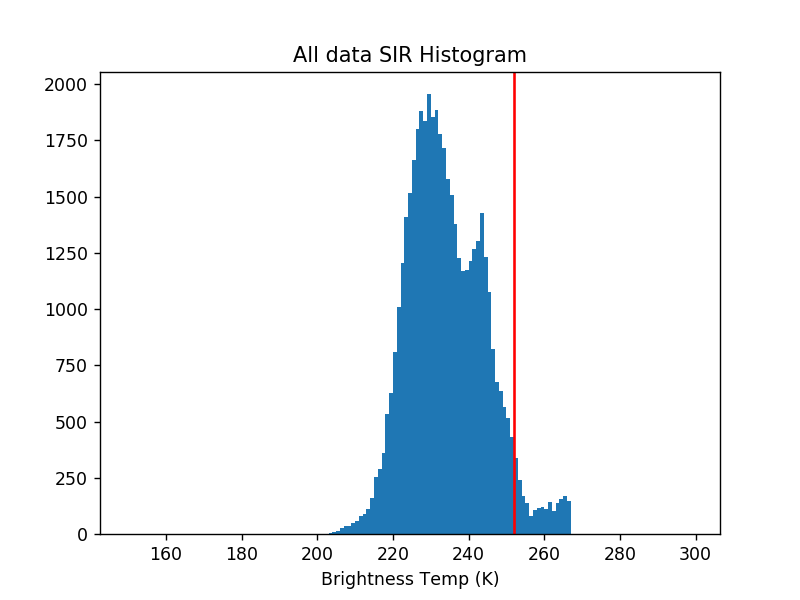

In [57]:
# generate histogram - SIR - all data
#year=2005
#Tb_threshold=252
data = CETB_SIR[:] # CETB_data for all pixels in subset
data = data[data>=0]
bins = range(150,300)  # bins for histogram
fig,ax=plt.subplots()
ax.hist(data, bins)
ax.set_title('All data SIR Histogram')
ax.axvline(x=Tb_threshold, color='red')
#ax.set_title(prefix+'row'+str(x)+'col'+str(y))
ax.set_xlabel('Brightness Temp (K)')
#fig.savefig('/home/mij216/Documents/GLaIL/'+prefix+'row'+str(x)+'col'+str(y)+'.png')
plt.savefig('../../jmr_plots/testIceland_Katla_F182019_HISTsirall.png')

<IPython.core.display.Javascript object>


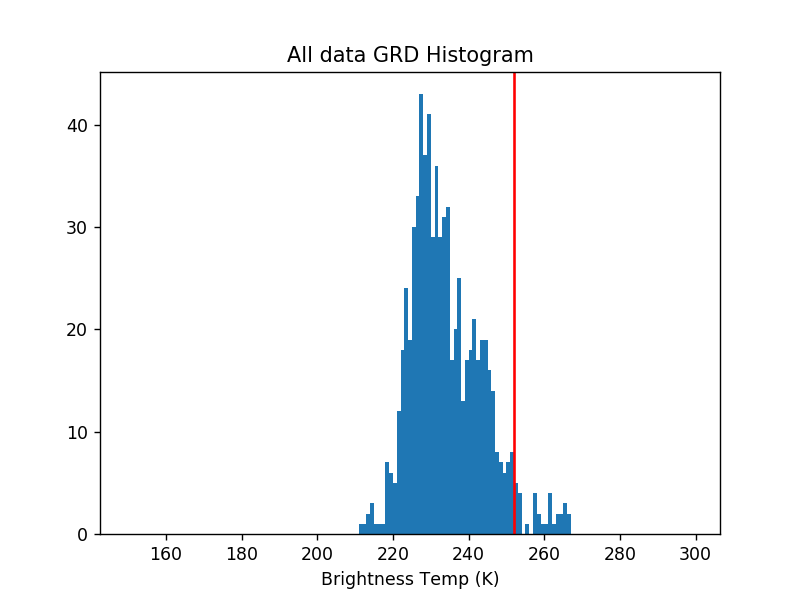

In [58]:
# generate histogram - GRD - all data
data = CETB_GRD[:] # CETB_data for all pixels in subset
data = data[data>=0]
bins = range(150,300)  # bins for histogram
fig,ax=plt.subplots()
ax.hist(data, bins)
ax.set_title('All data GRD Histogram')
ax.axvline(x=Tb_threshold, color='red')
#ax.set_title(prefix+'row'+str(x)+'col'+str(y))
ax.set_xlabel('Brightness Temp (K)')
#fig.savefig('/home/mij216/Documents/GLaIL/'+prefix+'row'+str(x)+'col'+str(y)+'.png')
plt.savefig('../../jmr_plots/testIceland_Katla_f18_histGRDall.png')

In [59]:
# min/max/avg time series and histogram of the 64 SIR pixels, plus the GRD pixel
year=2019
min_max_series(CETB_GRD, CETB_SIR, cal_date, cal_year, year, str(lat_start)+'_'+str(lon_start))
plt.savefig('../../jmr_plots/testIceland_site4Vatna_f18_minmaxhists2019.png')

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

## TIME SERIES

<IPython.core.display.Javascript object>


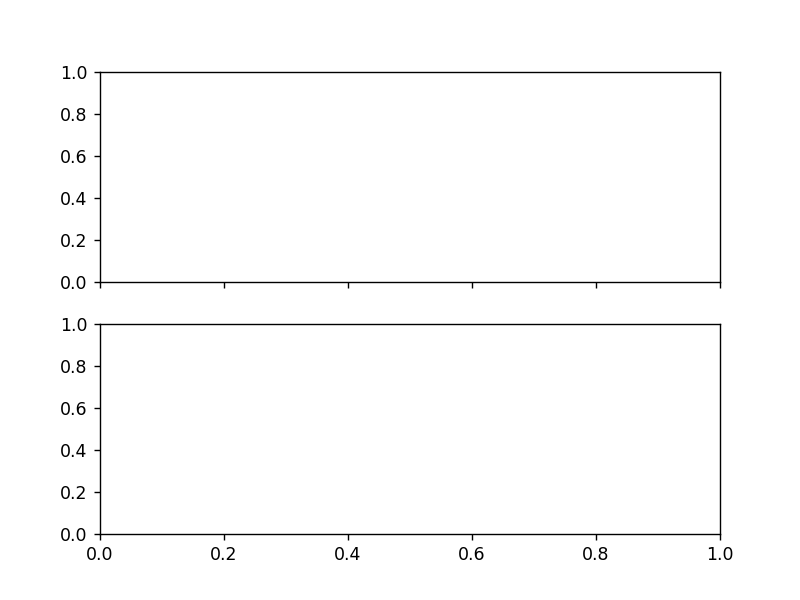

TypeError: only integer scalar arrays can be converted to a scalar index

In [60]:
# Tb and DAV time series for GRD pixel, pick one year
#year=2003
Tb_threshold=252
DAV_threshold=18
TbDAV_series_one_year(CETB_GRD,DAV_GRD, cal_date, cal_year, year, Tb_threshold, DAV_threshold)

<IPython.core.display.Javascript object>


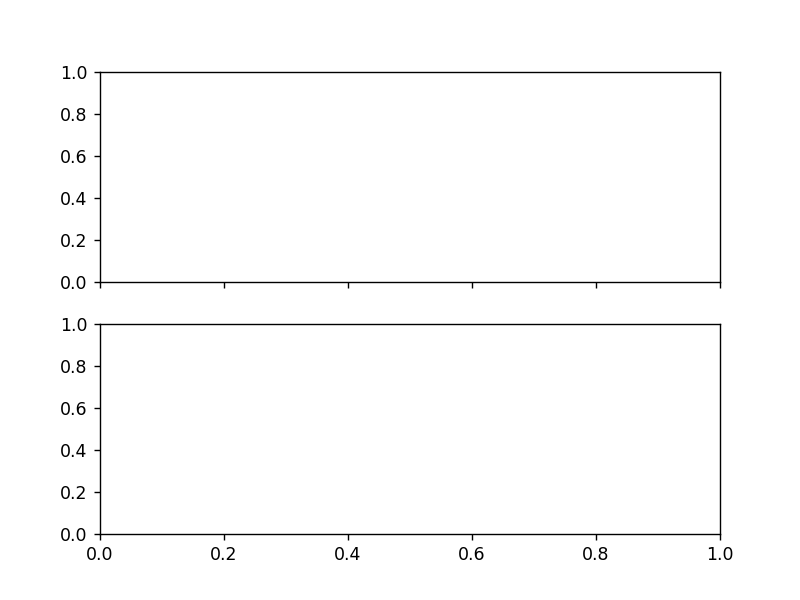

TypeError: only integer scalar arrays can be converted to a scalar index

In [61]:
# Tb and DAV time series for SIR pixels, pick one year
#year=2003
#Tb_threshold=252
#DAV_threshold=18
TbDAV_series_one_year(CETB_SIR, DAV_SIR, cal_date, cal_year, year, Tb_threshold, DAV_threshold)

In [62]:
# Tb and DAV time series of the single SIR pixel closest to the user-specified lat/lon at top of notebook
year=2019
#Tb_threshold=252
#DAV_threshold=18
data=read_Tb(datadir_SIR, prefix_SIR, Years,rows_cols[0][0],rows_cols[0][0]+1,rows_cols[1][0],rows_cols[1][0]+1)
SIR_1px=data[0]
DAV_1px=calc_DAV(SIR_1px)
TbDAV_series_one_year(SIR_1px, DAV_1px, cal_date, cal_year, year, Tb_threshold, DAV_threshold) 

IndexError: list index out of range

## CREATE CSVs

In [ ]:
TB_SIR_1px=pd.DataFrame([SIR_1px.flatten()]).T

TB_SIR_1px.index=cal_date
TB_SIR_1px

In [ ]:
DAV_SIR_1px=pd.DataFrame([DAV_1px.flatten()]).T
DAV_SIR_1px.index=cal_date
DAV_SIR_1px

In [ ]:
# CREATE CSV of GRD and SIR TB, GRD and SIR64 ST, and GRD And SIR DAV

# CREATE CSV OF TB, DAV, SD and sirSD FOR THE GRD PIXEL - ALL YEARS
Tb_frame=pd.DataFrame(CETB_GRD[:,0,0], index=cal_date)
DAV_frame=pd.DataFrame(DAV_GRD[:,0,0], index=cal_date)
GRD_data_out=pd.concat([Tb_frame,DAV_frame,TB_SIR_1px,DAV_SIR_1px,Tb_sd_frame_GRD,Tb_std_64,Tb_sd_diff],axis=1)
GRD_data_out.columns=['GRDTb36V','GRDDAV36V','SIRTB36V','SIRDAV36V','GRD_SD_36V','SIR64_to_SD_36V','SD_diff[GRD-SIR]']
GRD_data_out

In [ ]:
GRD_data_out.to_csv('/home/jmr204/noisy/sd/'+sat_GRD+'_'+sensor_GRD+'-'+channel_GRD+'-'+alg_GRD+'_'+str(lat_start)+'_'+str(lon_start)+'DATA.csv')  # modify destination to save csv

In [ ]:
# CREATE CSV OF TB FOR THE GRD PIXEL - ALL YEARS
Tb_frame=pd.DataFrame(CETB_GRD[:,0,0], index=cal_date)
Tb_frame.to_csv('/home/jmr204/noisy/noisytb_csv/'+sat_GRD+'_'+sensor_GRD+'-'+channel_GRD+'-'+alg_GRD+'_'+str(lat_start)+'_'+str(lon_start)+'.csv')  # modify destination to save csv

In [ ]:
# CREATE CSV of DAV FOR THE GRD PIXEL - ALL YEARS
DAV_frame=pd.DataFrame(DAV_GRD[:,0,0], index=cal_date)
DAV_frame.to_csv('/home/jmr204/noisy/noisydav_csv/'+sat_GRD+'_'+sensor_GRD+'-'+channel_GRD+'-'+alg_GRD+'_'+str(lat_start)+'_'+str(lon_start)+'.csv') # modify destination to save csv

In [ ]:
# CREATE CSV of TB FOR 64pixel subset OF SIR PIXELS - ALL YEARS
Tb_frame=pd.DataFrame()
for i in y_dims_list:
    for j in x_dims_list:
        column=pd.DataFrame(data=CETB_SIR[:,i,j], columns=[str(y_s[i])+','+str(x_s[j])])
        Tb_frame=pd.concat([Tb_frame,column],axis=1)
Tb_frame=Tb_frame.set_index(cal_date)
Tb_frame.to_csv('/home/jmr204/noisy/noisytbSIR_csv/'+sat_GRD+'_'+sensor_GRD+'-'+channel_GRD+'-'+alg_GRD+'_'+str(lat_start)+'_'+str(lon_start)+'.csv')  # modify destination to save csv

In [ ]:
# CREATE CSV of DAV FOR 64pixel subset OF SIR PIXELS - ALL YEARS
DAV_frame=pd.DataFrame()
for i in y_dims_list:
    for j in x_dims_list:
        column=pd.DataFrame(data=DAV_SIR[:,i,j], columns=[str(y_s[i])+','+str(x_s[j])])
        DAV_frame=pd.concat([DAV_frame,column],axis=1)
DAV_frame=DAV_frame.set_index(cal_date)
DAV_frame.to_csv('/home/jmr204/noisy/noisydavSIR_csv/'+sat_GRD+'_'+sensor_GRD+'-'+channel_GRD+'-'+alg_GRD+'_'+str(lat_start)+'_'+str(lon_start)+'.csv')  # modify destination to save csv

